In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.data_causl import *
from frengression import *
device = torch.device('cpu')

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
# import src.exp_utils as exp_utils

from matplotlib import pyplot as plt


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True


In [2]:
df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
if binary_intervention:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
else:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
# model.train_xz(x_tr, z_tr, num_iters=1000, lr=1e-4, print_every_iter=100)
model.train_y(x_tr, z_tr, y_tr, num_iters=300, lr=1e-4, print_every_iter=100)

Epoch 1: loss 2.2137,	loss_y 1.4249, 1.4418, 0.0337,	loss_eta 0.7887, 0.8320, 0.0866
Epoch 100: loss 1.2953,	loss_y 0.6614, 1.4112, 1.4996,	loss_eta 0.6339, 1.0005, 0.7331
Epoch 200: loss 1.5190,	loss_y 0.7352, 1.4332, 1.3960,	loss_eta 0.7838, 1.0181, 0.4686
Epoch 300: loss 1.3824,	loss_y 0.7286, 1.3600, 1.2629,	loss_eta 0.6538, 0.8521, 0.3966


# Evaluate Y|do(X)
We mainly compare causal margin under binary treatments. P0, P1 store Ys sampled from fitted frengression under control and treatment, respectively. Q0, Q1 store Ys sampled from true Y|do(X) under control and treatment, respectively.

# Log performance varying iterations.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform

# Define the tracker
tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

In [3]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 0.9184, loss1 0.9806, loss2 0.1244
Epoch 100: loss 0.6962, loss1 1.2994, loss2 1.2064
Epoch 200: loss 0.6747, loss1 1.3290, loss2 1.3086
Epoch 300: loss 0.6757, loss1 1.3245, loss2 1.2975
Epoch 400: loss 0.6381, loss1 1.3036, loss2 1.3310
Epoch 500: loss 0.6683, loss1 1.3706, loss2 1.4047
Epoch 1: loss 2.1545,	loss_y 1.4410, 1.4494, 0.0169,	loss_eta 0.7135, 0.7774, 0.1278
Epoch 100: loss 1.2341,	loss_y 0.6406, 1.3794, 1.4778,	loss_eta 0.5935, 1.1537, 1.1204
Epoch 200: loss 1.3860,	loss_y 0.6851, 1.2827, 1.1952,	loss_eta 0.7010, 0.8878, 0.3736
Epoch 300: loss 1.1052,	loss_y 0.5043, 1.0378, 1.0669,	loss_eta 0.6009, 1.0093, 0.8167
Epoch 400: loss 1.2482,	loss_y 0.6044, 1.4419, 1.6749,	loss_eta 0.6438, 1.2835, 1.2795
Epoch 500: loss 1.5154,	loss_y 0.8198, 1.2428, 0.8460,	loss_eta 0.6956, 1.0810, 0.7709
Epoch 1: loss 0.6680, loss1 1.3497, loss2 1.3633
Epoch 100: loss 0.6894, loss1 1.3360, loss2 1.2933
Epoch 200: loss 0.6845, loss1 1.3226, loss2 1.2761
Epoch 300: loss 0.6431, l

  3%|▎         | 1/30 [01:14<35:55, 74.34s/it]

Epoch 500: loss 1.0564,	loss_y 0.4996, 0.9569, 0.9146,	loss_eta 0.5568, 1.1295, 1.1453
Epoch 1: loss 0.9382, loss1 0.9835, loss2 0.0907
Epoch 100: loss 0.6395, loss1 1.2853, loss2 1.2917
Epoch 200: loss 0.6530, loss1 1.2861, loss2 1.2662
Epoch 300: loss 0.6749, loss1 1.2860, loss2 1.2222
Epoch 400: loss 0.6523, loss1 1.2909, loss2 1.2771
Epoch 500: loss 0.6846, loss1 1.3245, loss2 1.2799
Epoch 1: loss 2.1233,	loss_y 1.3607, 1.3992, 0.0768,	loss_eta 0.7625, 0.7899, 0.0548
Epoch 100: loss 1.3304,	loss_y 0.7208, 1.7930, 2.1444,	loss_eta 0.6096, 1.0222, 0.8252
Epoch 200: loss 1.4568,	loss_y 0.8333, 1.3306, 0.9946,	loss_eta 0.6235, 0.9498, 0.6525
Epoch 300: loss 1.2716,	loss_y 0.6258, 1.4182, 1.5849,	loss_eta 0.6459, 0.8538, 0.4159
Epoch 400: loss 1.3653,	loss_y 0.6670, 1.6003, 1.8666,	loss_eta 0.6984, 1.0500, 0.7033
Epoch 500: loss 1.2574,	loss_y 0.6749, 1.4417, 1.5336,	loss_eta 0.5825, 1.3272, 1.4893
Epoch 1: loss 0.6814, loss1 1.3191, loss2 1.2755
Epoch 100: loss 0.6574, loss1 1.3146, lo

  7%|▋         | 2/30 [02:12<30:17, 64.92s/it]

Epoch 500: loss 1.0776,	loss_y 0.4933, 1.0361, 1.0856,	loss_eta 0.5843, 1.1697, 1.1709
Epoch 1: loss 0.9852, loss1 1.0267, loss2 0.0831
Epoch 100: loss 0.7027, loss1 1.3750, loss2 1.3447
Epoch 200: loss 0.6899, loss1 1.3540, loss2 1.3282
Epoch 300: loss 0.7036, loss1 1.3877, loss2 1.3680
Epoch 400: loss 0.6842, loss1 1.3906, loss2 1.4129
Epoch 500: loss 0.6810, loss1 1.3513, loss2 1.3406
Epoch 1: loss 2.2629,	loss_y 1.4743, 1.4989, 0.0492,	loss_eta 0.7886, 0.8238, 0.0703
Epoch 100: loss 1.2897,	loss_y 0.7029, 1.6753, 1.9447,	loss_eta 0.5868, 0.9966, 0.8196
Epoch 200: loss 1.6432,	loss_y 0.8772, 1.2977, 0.8410,	loss_eta 0.7661, 1.0135, 0.4949
Epoch 300: loss 1.3133,	loss_y 0.6129, 1.4779, 1.7300,	loss_eta 0.7004, 0.8816, 0.3624
Epoch 400: loss 1.3234,	loss_y 0.6920, 1.7071, 2.0302,	loss_eta 0.6314, 0.8397, 0.4166
Epoch 500: loss 1.5197,	loss_y 0.9411, 1.4492, 1.0161,	loss_eta 0.5786, 1.0070, 0.8568
Epoch 1: loss 0.6822, loss1 1.3299, loss2 1.2954
Epoch 100: loss 0.6620, loss1 1.3394, lo

 10%|█         | 3/30 [03:12<28:05, 62.43s/it]

Epoch 500: loss 1.0920,	loss_y 0.5250, 1.0409, 1.0317,	loss_eta 0.5670, 1.1683, 1.2027
Epoch 1: loss 0.9490, loss1 0.9769, loss2 0.0558
Epoch 100: loss 0.6802, loss1 1.3118, loss2 1.2631
Epoch 200: loss 0.6599, loss1 1.2974, loss2 1.2751
Epoch 300: loss 0.6590, loss1 1.3077, loss2 1.2975
Epoch 400: loss 0.6398, loss1 1.2996, loss2 1.3196
Epoch 500: loss 0.6441, loss1 1.2664, loss2 1.2445
Epoch 1: loss 2.1916,	loss_y 1.4225, 1.4586, 0.0721,	loss_eta 0.7690, 0.8029, 0.0677
Epoch 100: loss 1.2646,	loss_y 0.6214, 1.7089, 2.1750,	loss_eta 0.6432, 1.0098, 0.7333
Epoch 200: loss 1.3119,	loss_y 0.6282, 0.9360, 0.6156,	loss_eta 0.6837, 0.9178, 0.4682
Epoch 300: loss 1.0868,	loss_y 0.5403, 1.2673, 1.4539,	loss_eta 0.5465, 0.9562, 0.8193
Epoch 400: loss 1.5712,	loss_y 0.9132, 1.3816, 0.9368,	loss_eta 0.6580, 0.8783, 0.4405
Epoch 500: loss 1.3649,	loss_y 0.7257, 1.0930, 0.7346,	loss_eta 0.6392, 0.8923, 0.5063
Epoch 1: loss 0.6699, loss1 1.2900, loss2 1.2401
Epoch 100: loss 0.6824, loss1 1.3425, lo

 13%|█▎        | 4/30 [04:17<27:28, 63.42s/it]

Epoch 500: loss 1.0604,	loss_y 0.4807, 0.9350, 0.9085,	loss_eta 0.5797, 1.1223, 1.0854
Epoch 1: loss 0.9779, loss1 1.0220, loss2 0.0882
Epoch 100: loss 0.7015, loss1 1.3168, loss2 1.2305
Epoch 200: loss 0.6787, loss1 1.3274, loss2 1.2973
Epoch 300: loss 0.6742, loss1 1.3200, loss2 1.2914
Epoch 400: loss 0.6499, loss1 1.3182, loss2 1.3367
Epoch 500: loss 0.6782, loss1 1.3337, loss2 1.3110
Epoch 1: loss 2.1835,	loss_y 1.3814, 1.4060, 0.0492,	loss_eta 0.8020, 0.8505, 0.0969
Epoch 100: loss 1.2941,	loss_y 0.7228, 1.8374, 2.2293,	loss_eta 0.5714, 1.0383, 0.9338
Epoch 200: loss 1.2309,	loss_y 0.6683, 1.0387, 0.7407,	loss_eta 0.5625, 1.1669, 1.2086
Epoch 300: loss 1.3570,	loss_y 0.7912, 1.6184, 1.6544,	loss_eta 0.5658, 0.9939, 0.8562
Epoch 400: loss 1.4202,	loss_y 0.6033, 1.5488, 1.8910,	loss_eta 0.8170, 1.1702, 0.7064
Epoch 500: loss 1.3575,	loss_y 0.7887, 1.1579, 0.7383,	loss_eta 0.5688, 0.9312, 0.7249
Epoch 1: loss 0.6677, loss1 1.3393, loss2 1.3432
Epoch 100: loss 0.7040, loss1 1.3612, lo

 17%|█▋        | 5/30 [05:18<26:10, 62.83s/it]

Epoch 500: loss 1.0687,	loss_y 0.4978, 1.0320, 1.0684,	loss_eta 0.5709, 1.1231, 1.1044
Epoch 1: loss 0.9589, loss1 0.9965, loss2 0.0751
Epoch 100: loss 0.7068, loss1 1.3771, loss2 1.3407
Epoch 200: loss 0.6546, loss1 1.3171, loss2 1.3250
Epoch 300: loss 0.6879, loss1 1.3438, loss2 1.3118
Epoch 400: loss 0.6711, loss1 1.3185, loss2 1.2948
Epoch 500: loss 0.6560, loss1 1.3550, loss2 1.3979
Epoch 1: loss 2.3083,	loss_y 1.5478, 1.5722, 0.0488,	loss_eta 0.7604, 0.7976, 0.0743
Epoch 100: loss 1.4029,	loss_y 0.7435, 1.7795, 2.0719,	loss_eta 0.6594, 0.8996, 0.4805
Epoch 200: loss 1.4926,	loss_y 0.7783, 1.2293, 0.9020,	loss_eta 0.7143, 0.9778, 0.5269
Epoch 300: loss 1.4420,	loss_y 0.8919, 2.0800, 2.3760,	loss_eta 0.5501, 0.9082, 0.7163
Epoch 400: loss 1.4958,	loss_y 0.7779, 1.9083, 2.2607,	loss_eta 0.7179, 1.3001, 1.1646
Epoch 500: loss 1.3860,	loss_y 0.7370, 1.5024, 1.5309,	loss_eta 0.6491, 1.4232, 1.5484
Epoch 1: loss 0.6590, loss1 1.3500, loss2 1.3820
Epoch 100: loss 0.6782, loss1 1.3475, lo

 20%|██        | 6/30 [06:38<27:26, 68.62s/it]

Epoch 500: loss 1.0915,	loss_y 0.5421, 1.0846, 1.0849,	loss_eta 0.5494, 1.1709, 1.2431
Epoch 1: loss 0.9740, loss1 1.0228, loss2 0.0976
Epoch 100: loss 0.6825, loss1 1.3677, loss2 1.3704
Epoch 200: loss 0.6879, loss1 1.3508, loss2 1.3259
Epoch 300: loss 0.7190, loss1 1.3781, loss2 1.3182
Epoch 400: loss 0.7281, loss1 1.4064, loss2 1.3567
Epoch 500: loss 0.6803, loss1 1.3833, loss2 1.4060
Epoch 1: loss 2.2616,	loss_y 1.5123, 1.5322, 0.0397,	loss_eta 0.7492, 0.7850, 0.0715
Epoch 100: loss 1.2126,	loss_y 0.6663, 1.8093, 2.2861,	loss_eta 0.5463, 0.9218, 0.7508
Epoch 200: loss 1.5092,	loss_y 0.9471, 1.4027, 0.9113,	loss_eta 0.5621, 1.0504, 0.9765
Epoch 300: loss 1.4202,	loss_y 0.8152, 1.4924, 1.3543,	loss_eta 0.6050, 1.0515, 0.8930
Epoch 400: loss 1.6320,	loss_y 1.0386, 2.4962, 2.9153,	loss_eta 0.5934, 0.9987, 0.8105
Epoch 500: loss 1.5009,	loss_y 0.8781, 1.6337, 1.5112,	loss_eta 0.6228, 1.5692, 1.8929
Epoch 1: loss 0.6694, loss1 1.3506, loss2 1.3626
Epoch 100: loss 0.6569, loss1 1.3391, lo

 23%|██▎       | 7/30 [07:40<25:25, 66.32s/it]

Epoch 500: loss 1.1182,	loss_y 0.5230, 1.0789, 1.1118,	loss_eta 0.5952, 1.1997, 1.2090
Epoch 1: loss 0.9800, loss1 1.0048, loss2 0.0496
Epoch 100: loss 0.6948, loss1 1.3397, loss2 1.2898
Epoch 200: loss 0.6809, loss1 1.3672, loss2 1.3726
Epoch 300: loss 0.6610, loss1 1.3844, loss2 1.4467
Epoch 400: loss 0.6866, loss1 1.3339, loss2 1.2946
Epoch 500: loss 0.6733, loss1 1.3448, loss2 1.3429
Epoch 1: loss 2.1389,	loss_y 1.3825, 1.4059, 0.0468,	loss_eta 0.7564, 0.8104, 0.1079
Epoch 100: loss 1.2522,	loss_y 0.6287, 1.1446, 1.0318,	loss_eta 0.6235, 1.1794, 1.1117
Epoch 200: loss 1.4088,	loss_y 0.7053, 1.2579, 1.1052,	loss_eta 0.7035, 0.8718, 0.3366
Epoch 300: loss 1.3518,	loss_y 0.6910, 1.6610, 1.9400,	loss_eta 0.6608, 0.8824, 0.4432
Epoch 400: loss 1.4572,	loss_y 0.7874, 1.2393, 0.9038,	loss_eta 0.6698, 0.8198, 0.3000
Epoch 500: loss 1.4146,	loss_y 0.8022, 1.8845, 2.1646,	loss_eta 0.6124, 1.1742, 1.1237
Epoch 1: loss 0.6909, loss1 1.3857, loss2 1.3895
Epoch 100: loss 0.7024, loss1 1.3680, lo

 27%|██▋       | 8/30 [08:38<23:25, 63.89s/it]

Epoch 500: loss 1.1492,	loss_y 0.6015, 1.1276, 1.0521,	loss_eta 0.5476, 1.1478, 1.2004
Epoch 1: loss 0.9452, loss1 1.0108, loss2 0.1311
Epoch 100: loss 0.7178, loss1 1.3432, loss2 1.2507
Epoch 200: loss 0.7170, loss1 1.3604, loss2 1.2868
Epoch 300: loss 0.6796, loss1 1.3300, loss2 1.3008
Epoch 400: loss 0.6505, loss1 1.3375, loss2 1.3741
Epoch 500: loss 0.6948, loss1 1.3672, loss2 1.3447
Epoch 1: loss 2.2764,	loss_y 1.4814, 1.4954, 0.0280,	loss_eta 0.7950, 0.8234, 0.0567
Epoch 100: loss 1.2918,	loss_y 0.6505, 1.6559, 2.0109,	loss_eta 0.6414, 1.0832, 0.8836
Epoch 200: loss 1.2416,	loss_y 0.5525, 0.8665, 0.6281,	loss_eta 0.6891, 0.8478, 0.3173
Epoch 300: loss 1.2888,	loss_y 0.6561, 1.3146, 1.3169,	loss_eta 0.6326, 1.0052, 0.7451
Epoch 400: loss 2.0507,	loss_y 1.4665, 2.8463, 2.7595,	loss_eta 0.5842, 1.1753, 1.1823
Epoch 500: loss 1.7748,	loss_y 0.9950, 1.7712, 1.5523,	loss_eta 0.7798, 1.3843, 1.2088
Epoch 1: loss 0.7049, loss1 1.3789, loss2 1.3480
Epoch 100: loss 0.6806, loss1 1.3619, lo

 30%|███       | 9/30 [09:40<22:07, 63.23s/it]

Epoch 500: loss 1.0331,	loss_y 0.4940, 1.0146, 1.0412,	loss_eta 0.5391, 1.1199, 1.1616
Epoch 1: loss 0.9775, loss1 1.0019, loss2 0.0487
Epoch 100: loss 0.7003, loss1 1.3786, loss2 1.3566
Epoch 200: loss 0.6954, loss1 1.3376, loss2 1.2844
Epoch 300: loss 0.6571, loss1 1.3294, loss2 1.3446
Epoch 400: loss 0.6522, loss1 1.3089, loss2 1.3133
Epoch 500: loss 0.6656, loss1 1.3015, loss2 1.2719
Epoch 1: loss 2.2348,	loss_y 1.4826, 1.4970, 0.0289,	loss_eta 0.7522, 0.8132, 0.1219
Epoch 100: loss 1.4822,	loss_y 0.9103, 1.1810, 0.5413,	loss_eta 0.5719, 1.0544, 0.9651
Epoch 200: loss 1.3768,	loss_y 0.7709, 1.4871, 1.4323,	loss_eta 0.6059, 1.0360, 0.8602
Epoch 300: loss 1.5105,	loss_y 0.7168, 1.3557, 1.2779,	loss_eta 0.7937, 1.4314, 1.2753
Epoch 400: loss 1.3575,	loss_y 0.6412, 1.2350, 1.1877,	loss_eta 0.7163, 1.2783, 1.1239
Epoch 500: loss 1.2284,	loss_y 0.5712, 1.2264, 1.3105,	loss_eta 0.6573, 1.1145, 0.9145
Epoch 1: loss 0.6824, loss1 1.3047, loss2 1.2446
Epoch 100: loss 0.6917, loss1 1.3337, lo

 33%|███▎      | 10/30 [10:47<21:27, 64.35s/it]

Epoch 500: loss 1.0930,	loss_y 0.5270, 1.0584, 1.0628,	loss_eta 0.5659, 1.1231, 1.1142
Epoch 1: loss 0.9654, loss1 1.0148, loss2 0.0987
Epoch 100: loss 0.7220, loss1 1.3788, loss2 1.3137
Epoch 200: loss 0.7157, loss1 1.3817, loss2 1.3318
Epoch 300: loss 0.7023, loss1 1.3387, loss2 1.2727
Epoch 400: loss 0.6817, loss1 1.3479, loss2 1.3323
Epoch 500: loss 0.6884, loss1 1.3781, loss2 1.3793
Epoch 1: loss 2.2619,	loss_y 1.4963, 1.5202, 0.0478,	loss_eta 0.7656, 0.7831, 0.0351
Epoch 100: loss 1.3225,	loss_y 0.7548, 1.9730, 2.4364,	loss_eta 0.5677, 1.0340, 0.9326
Epoch 200: loss 1.2296,	loss_y 0.6447, 1.1425, 0.9956,	loss_eta 0.5849, 1.1321, 1.0944
Epoch 300: loss 1.7102,	loss_y 1.0074, 1.6985, 1.3823,	loss_eta 0.7029, 0.8478, 0.2898
Epoch 400: loss 1.6237,	loss_y 0.9732, 2.1639, 2.3814,	loss_eta 0.6505, 1.1782, 1.0556
Epoch 500: loss 1.6314,	loss_y 0.9279, 1.3534, 0.8509,	loss_eta 0.7035, 1.1404, 0.8737
Epoch 1: loss 0.7005, loss1 1.3878, loss2 1.3745
Epoch 100: loss 0.7102, loss1 1.3894, lo

 37%|███▋      | 11/30 [11:52<20:28, 64.65s/it]

Epoch 500: loss 1.0434,	loss_y 0.5120, 0.9892, 0.9544,	loss_eta 0.5314, 1.1754, 1.2880
Epoch 1: loss 0.9456, loss1 0.9893, loss2 0.0875
Epoch 100: loss 0.6867, loss1 1.3149, loss2 1.2565
Epoch 200: loss 0.6742, loss1 1.3532, loss2 1.3579
Epoch 300: loss 0.6684, loss1 1.3254, loss2 1.3141
Epoch 400: loss 0.6875, loss1 1.3605, loss2 1.3459
Epoch 500: loss 0.6803, loss1 1.3548, loss2 1.3491
Epoch 1: loss 2.2281,	loss_y 1.4814, 1.4931, 0.0235,	loss_eta 0.7467, 0.7869, 0.0804
Epoch 100: loss 1.1447,	loss_y 0.5819, 1.6681, 2.1725,	loss_eta 0.5628, 1.0561, 0.9865
Epoch 200: loss 1.3120,	loss_y 0.6050, 1.0154, 0.8207,	loss_eta 0.7070, 0.8255, 0.2371
Epoch 300: loss 1.4002,	loss_y 0.6969, 1.3606, 1.3273,	loss_eta 0.7034, 0.8986, 0.3905
Epoch 400: loss 1.2312,	loss_y 0.6344, 1.3795, 1.4903,	loss_eta 0.5968, 0.9697, 0.7459
Epoch 500: loss 1.0948,	loss_y 0.5591, 1.4079, 1.6976,	loss_eta 0.5356, 1.1455, 1.2198
Epoch 1: loss 0.7073, loss1 1.3721, loss2 1.3296
Epoch 100: loss 0.6654, loss1 1.3426, lo

 40%|████      | 12/30 [12:57<19:24, 64.69s/it]

Epoch 500: loss 1.0938,	loss_y 0.5329, 1.0759, 1.0860,	loss_eta 0.5610, 1.1339, 1.1458
Epoch 1: loss 0.9835, loss1 1.0199, loss2 0.0727
Epoch 100: loss 0.7198, loss1 1.3504, loss2 1.2612
Epoch 200: loss 0.6666, loss1 1.3738, loss2 1.4144
Epoch 300: loss 0.6863, loss1 1.3377, loss2 1.3028
Epoch 400: loss 0.6908, loss1 1.3704, loss2 1.3591
Epoch 500: loss 0.6999, loss1 1.3609, loss2 1.3220
Epoch 1: loss 2.2630,	loss_y 1.4694, 1.4851, 0.0315,	loss_eta 0.7937, 0.8191, 0.0509
Epoch 100: loss 1.2677,	loss_y 0.6443, 1.7296, 2.1706,	loss_eta 0.6234, 0.8999, 0.5528
Epoch 200: loss 1.3010,	loss_y 0.6534, 0.9058, 0.5048,	loss_eta 0.6476, 0.8923, 0.4894
Epoch 300: loss 1.6691,	loss_y 1.0486, 2.2974, 2.4976,	loss_eta 0.6206, 1.3903, 1.5396
Epoch 400: loss 1.2895,	loss_y 0.6593, 1.1944, 1.0703,	loss_eta 0.6302, 1.0160, 0.7715
Epoch 500: loss 1.4732,	loss_y 0.7201, 1.3586, 1.2770,	loss_eta 0.7532, 1.0107, 0.5151
Epoch 1: loss 0.7026, loss1 1.3733, loss2 1.3413
Epoch 100: loss 0.7097, loss1 1.3826, lo

 43%|████▎     | 13/30 [14:03<18:22, 64.87s/it]

Epoch 500: loss 1.1092,	loss_y 0.5236, 1.0548, 1.0624,	loss_eta 0.5856, 1.1752, 1.1792
Epoch 1: loss 0.9445, loss1 0.9862, loss2 0.0834
Epoch 100: loss 0.7024, loss1 1.3640, loss2 1.3231
Epoch 200: loss 0.7144, loss1 1.3468, loss2 1.2647
Epoch 300: loss 0.6805, loss1 1.3319, loss2 1.3028
Epoch 400: loss 0.6798, loss1 1.3560, loss2 1.3524
Epoch 500: loss 0.6653, loss1 1.3333, loss2 1.3359
Epoch 1: loss 2.2239,	loss_y 1.4313, 1.4711, 0.0796,	loss_eta 0.7926, 0.8305, 0.0758
Epoch 100: loss 1.2423,	loss_y 0.6850, 1.7248, 2.0796,	loss_eta 0.5572, 0.9527, 0.7909
Epoch 200: loss 1.2706,	loss_y 0.6065, 0.9309, 0.6488,	loss_eta 0.6641, 0.8977, 0.4670
Epoch 300: loss 1.5780,	loss_y 1.0277, 2.0472, 2.0390,	loss_eta 0.5503, 1.1259, 1.1512
Epoch 400: loss 1.4823,	loss_y 0.8029, 1.2683, 0.9307,	loss_eta 0.6794, 1.1186, 0.8785
Epoch 500: loss 1.3540,	loss_y 0.6301, 1.1802, 1.1003,	loss_eta 0.7239, 0.8444, 0.2409
Epoch 1: loss 0.6922, loss1 1.3708, loss2 1.3573
Epoch 100: loss 0.6813, loss1 1.3253, lo

 47%|████▋     | 14/30 [15:07<17:17, 64.81s/it]

Epoch 500: loss 1.0471,	loss_y 0.4832, 0.9879, 1.0094,	loss_eta 0.5639, 1.0672, 1.0064
Epoch 1: loss 0.9585, loss1 0.9853, loss2 0.0534
Epoch 100: loss 0.6729, loss1 1.3223, loss2 1.2988
Epoch 200: loss 0.6619, loss1 1.3219, loss2 1.3200
Epoch 300: loss 0.6374, loss1 1.2836, loss2 1.2925
Epoch 400: loss 0.6568, loss1 1.3302, loss2 1.3468
Epoch 500: loss 0.6643, loss1 1.3224, loss2 1.3161
Epoch 1: loss 2.1848,	loss_y 1.3962, 1.4134, 0.0344,	loss_eta 0.7886, 0.8053, 0.0332
Epoch 100: loss 1.2748,	loss_y 0.7038, 1.8598, 2.3118,	loss_eta 0.5709, 1.0175, 0.8931
Epoch 200: loss 1.4179,	loss_y 0.6748, 0.8915, 0.4333,	loss_eta 0.7431, 0.8692, 0.2522
Epoch 300: loss 1.4032,	loss_y 0.8147, 2.0463, 2.4631,	loss_eta 0.5885, 0.8957, 0.6145
Epoch 400: loss 1.4050,	loss_y 0.8319, 1.6111, 1.5583,	loss_eta 0.5731, 0.9823, 0.8185
Epoch 500: loss 1.5211,	loss_y 0.8926, 1.8017, 1.8181,	loss_eta 0.6286, 1.2392, 1.2213
Epoch 1: loss 0.6757, loss1 1.3329, loss2 1.3144
Epoch 100: loss 0.6402, loss1 1.2777, lo

 50%|█████     | 15/30 [16:16<16:29, 65.96s/it]

Epoch 500: loss 1.0322,	loss_y 0.4924, 1.0364, 1.0880,	loss_eta 0.5398, 1.1566, 1.2335
Epoch 1: loss 0.9830, loss1 1.0170, loss2 0.0679
Epoch 100: loss 0.7074, loss1 1.3747, loss2 1.3346
Epoch 200: loss 0.6699, loss1 1.3335, loss2 1.3273
Epoch 300: loss 0.6711, loss1 1.3402, loss2 1.3381
Epoch 400: loss 0.6763, loss1 1.3673, loss2 1.3819
Epoch 500: loss 0.7104, loss1 1.3725, loss2 1.3241
Epoch 1: loss 2.2490,	loss_y 1.4834, 1.5079, 0.0491,	loss_eta 0.7656, 0.7878, 0.0443
Epoch 100: loss 1.3828,	loss_y 0.7655, 2.0156, 2.5002,	loss_eta 0.6173, 1.2841, 1.3337
Epoch 200: loss 1.2822,	loss_y 0.6528, 0.9683, 0.6310,	loss_eta 0.6294, 0.8292, 0.3997
Epoch 300: loss 1.2290,	loss_y 0.6041, 1.3488, 1.4893,	loss_eta 0.6249, 0.9497, 0.6497
Epoch 400: loss 1.3249,	loss_y 0.7247, 1.7860, 2.1227,	loss_eta 0.6002, 0.8862, 0.5720
Epoch 500: loss 1.2552,	loss_y 0.6436, 1.4961, 1.7050,	loss_eta 0.6116, 1.4418, 1.6604
Epoch 1: loss 0.6889, loss1 1.3550, loss2 1.3321
Epoch 100: loss 0.6581, loss1 1.3436, lo

 53%|█████▎    | 16/30 [17:22<15:25, 66.11s/it]

Epoch 500: loss 1.1027,	loss_y 0.5138, 1.0356, 1.0438,	loss_eta 0.5890, 1.1243, 1.0707
Epoch 1: loss 0.9424, loss1 0.9874, loss2 0.0900
Epoch 100: loss 0.6920, loss1 1.3284, loss2 1.2728
Epoch 200: loss 0.6864, loss1 1.3097, loss2 1.2466
Epoch 300: loss 0.6604, loss1 1.3146, loss2 1.3084
Epoch 400: loss 0.6526, loss1 1.2988, loss2 1.2924
Epoch 500: loss 0.6718, loss1 1.3176, loss2 1.2915
Epoch 1: loss 2.2439,	loss_y 1.4326, 1.4625, 0.0598,	loss_eta 0.8113, 0.8269, 0.0311
Epoch 100: loss 1.2651,	loss_y 0.6483, 1.7339, 2.1713,	loss_eta 0.6169, 1.0739, 0.9141
Epoch 200: loss 1.2865,	loss_y 0.6017, 0.8963, 0.5893,	loss_eta 0.6849, 0.9673, 0.5649
Epoch 300: loss 1.4967,	loss_y 0.9128, 1.4703, 1.1150,	loss_eta 0.5839, 1.0411, 0.9143
Epoch 400: loss 1.1767,	loss_y 0.5814, 1.6320, 2.1013,	loss_eta 0.5953, 1.2539, 1.3171
Epoch 500: loss 1.3389,	loss_y 0.6009, 1.3485, 1.4953,	loss_eta 0.7381, 1.1310, 0.7857
Epoch 1: loss 0.6681, loss1 1.3061, loss2 1.2759
Epoch 100: loss 0.6904, loss1 1.3649, lo

 57%|█████▋    | 17/30 [18:31<14:29, 66.92s/it]

Epoch 500: loss 1.0641,	loss_y 0.5142, 1.0153, 1.0022,	loss_eta 0.5499, 1.1410, 1.1822
Epoch 1: loss 0.9461, loss1 0.9922, loss2 0.0921
Epoch 100: loss 0.7060, loss1 1.3414, loss2 1.2708
Epoch 200: loss 0.6774, loss1 1.3418, loss2 1.3288
Epoch 300: loss 0.6604, loss1 1.3385, loss2 1.3562
Epoch 400: loss 0.7021, loss1 1.3678, loss2 1.3314
Epoch 500: loss 0.6984, loss1 1.3481, loss2 1.2994
Epoch 1: loss 2.1445,	loss_y 1.3826, 1.4236, 0.0819,	loss_eta 0.7619, 0.7958, 0.0678
Epoch 100: loss 1.4176,	loss_y 0.7217, 1.8078, 2.1723,	loss_eta 0.6959, 1.2868, 1.1817
Epoch 200: loss 1.3200,	loss_y 0.6957, 1.0250, 0.6588,	loss_eta 0.6243, 0.9210, 0.5934
Epoch 300: loss 1.1083,	loss_y 0.5284, 1.0936, 1.1304,	loss_eta 0.5800, 1.1907, 1.2214
Epoch 400: loss 1.5018,	loss_y 0.8299, 1.3803, 1.1008,	loss_eta 0.6719, 1.0241, 0.7043
Epoch 500: loss 1.3121,	loss_y 0.5907, 1.1669, 1.1524,	loss_eta 0.7214, 0.8817, 0.3205
Epoch 1: loss 0.6604, loss1 1.3501, loss2 1.3794
Epoch 100: loss 0.6409, loss1 1.3161, lo

 60%|██████    | 18/30 [19:40<13:28, 67.41s/it]

Epoch 500: loss 1.0347,	loss_y 0.4700, 0.9535, 0.9670,	loss_eta 0.5647, 1.1270, 1.1245
Epoch 1: loss 0.9722, loss1 1.0152, loss2 0.0860
Epoch 100: loss 0.6988, loss1 1.3797, loss2 1.3617
Epoch 200: loss 0.6679, loss1 1.3670, loss2 1.3982
Epoch 300: loss 0.7099, loss1 1.3885, loss2 1.3573
Epoch 400: loss 0.6972, loss1 1.3821, loss2 1.3697
Epoch 500: loss 0.6771, loss1 1.3693, loss2 1.3845
Epoch 1: loss 2.1921,	loss_y 1.4374, 1.4555, 0.0362,	loss_eta 0.7547, 0.7912, 0.0729
Epoch 100: loss 1.2840,	loss_y 0.6554, 1.7690, 2.2271,	loss_eta 0.6286, 1.3479, 1.4386
Epoch 200: loss 1.1597,	loss_y 0.5501, 0.8310, 0.5618,	loss_eta 0.6096, 1.1114, 1.0037
Epoch 300: loss 1.1125,	loss_y 0.5316, 1.4074, 1.7516,	loss_eta 0.5809, 0.9512, 0.7406
Epoch 400: loss 1.4619,	loss_y 0.7491, 2.1318, 2.7653,	loss_eta 0.7128, 1.2333, 1.0409
Epoch 500: loss 1.5202,	loss_y 0.8376, 1.3118, 0.9484,	loss_eta 0.6826, 1.1453, 0.9253
Epoch 1: loss 0.6737, loss1 1.3511, loss2 1.3547
Epoch 100: loss 0.7154, loss1 1.4088, lo

 63%|██████▎   | 19/30 [20:48<12:25, 67.74s/it]

Epoch 500: loss 1.0446,	loss_y 0.4951, 1.0218, 1.0533,	loss_eta 0.5495, 1.1150, 1.1311
Epoch 1: loss 0.9622, loss1 1.0288, loss2 0.1332
Epoch 100: loss 0.7193, loss1 1.3520, loss2 1.2655
Epoch 200: loss 0.6870, loss1 1.3857, loss2 1.3972
Epoch 300: loss 0.7057, loss1 1.3884, loss2 1.3655
Epoch 400: loss 0.7030, loss1 1.3780, loss2 1.3500
Epoch 500: loss 0.7164, loss1 1.4267, loss2 1.4206
Epoch 1: loss 2.1875,	loss_y 1.4415, 1.4510, 0.0190,	loss_eta 0.7460, 0.7691, 0.0461
Epoch 100: loss 1.3047,	loss_y 0.7167, 1.7732, 2.1130,	loss_eta 0.5880, 0.9551, 0.7343
Epoch 200: loss 1.3766,	loss_y 0.6360, 1.0743, 0.8765,	loss_eta 0.7406, 0.8549, 0.2286
Epoch 300: loss 1.6036,	loss_y 0.9600, 1.8551, 1.7902,	loss_eta 0.6436, 0.9005, 0.5138
Epoch 400: loss 1.3692,	loss_y 0.8422, 1.6346, 1.5849,	loss_eta 0.5270, 1.0476, 1.0411
Epoch 500: loss 1.2438,	loss_y 0.6151, 1.4051, 1.5800,	loss_eta 0.6288, 1.4684, 1.6793
Epoch 1: loss 0.7055, loss1 1.4118, loss2 1.4127
Epoch 100: loss 0.7043, loss1 1.3918, lo

 67%|██████▋   | 20/30 [21:55<11:15, 67.50s/it]

Epoch 500: loss 0.9937,	loss_y 0.4907, 1.0266, 1.0718,	loss_eta 0.5030, 1.1033, 1.2005
Epoch 1: loss 0.9605, loss1 0.9959, loss2 0.0709
Epoch 100: loss 0.6766, loss1 1.3285, loss2 1.3039
Epoch 200: loss 0.6892, loss1 1.3382, loss2 1.2981
Epoch 300: loss 0.6679, loss1 1.3487, loss2 1.3616
Epoch 400: loss 0.6888, loss1 1.3778, loss2 1.3780
Epoch 500: loss 0.6741, loss1 1.3234, loss2 1.2984
Epoch 1: loss 2.2533,	loss_y 1.4453, 1.4693, 0.0480,	loss_eta 0.8080, 0.8408, 0.0656
Epoch 100: loss 1.2505,	loss_y 0.6486, 1.7479, 2.1986,	loss_eta 0.6019, 0.9906, 0.7774
Epoch 200: loss 1.3132,	loss_y 0.6523, 0.9860, 0.6672,	loss_eta 0.6608, 0.9339, 0.5462
Epoch 300: loss 1.6852,	loss_y 1.0281, 2.1182, 2.1802,	loss_eta 0.6571, 1.4567, 1.5992
Epoch 400: loss 1.5229,	loss_y 0.8139, 1.2264, 0.8250,	loss_eta 0.7090, 1.0267, 0.6353
Epoch 500: loss 1.3250,	loss_y 0.6205, 1.4799, 1.7189,	loss_eta 0.7045, 1.1807, 0.9524
Epoch 1: loss 0.6816, loss1 1.3396, loss2 1.3161
Epoch 100: loss 0.6767, loss1 1.3497, lo

 70%|███████   | 21/30 [23:05<10:13, 68.17s/it]

Epoch 500: loss 1.0543,	loss_y 0.5185, 1.0202, 1.0034,	loss_eta 0.5358, 1.1372, 1.2028
Epoch 1: loss 0.9704, loss1 1.0109, loss2 0.0808
Epoch 100: loss 0.6666, loss1 1.3864, loss2 1.4397
Epoch 200: loss 0.6688, loss1 1.3665, loss2 1.3954
Epoch 300: loss 0.6669, loss1 1.3486, loss2 1.3634
Epoch 400: loss 0.7069, loss1 1.3531, loss2 1.2924
Epoch 500: loss 0.7083, loss1 1.3923, loss2 1.3681
Epoch 1: loss 2.2085,	loss_y 1.4528, 1.4683, 0.0310,	loss_eta 0.7557, 0.7749, 0.0384
Epoch 100: loss 1.2257,	loss_y 0.6410, 1.8211, 2.3604,	loss_eta 0.5847, 1.2109, 1.2524
Epoch 200: loss 1.3662,	loss_y 0.5581, 1.0033, 0.8905,	loss_eta 0.8082, 0.8909, 0.1655
Epoch 300: loss 1.2913,	loss_y 0.5669, 1.0507, 0.9675,	loss_eta 0.7244, 0.8385, 0.2284
Epoch 400: loss 1.4485,	loss_y 0.7790, 1.4493, 1.3407,	loss_eta 0.6695, 0.9961, 0.6533
Epoch 500: loss 1.3647,	loss_y 0.6177, 1.3543, 1.4733,	loss_eta 0.7470, 0.9324, 0.3707
Epoch 1: loss 0.6940, loss1 1.3558, loss2 1.3237
Epoch 100: loss 0.7275, loss1 1.4089, lo

 73%|███████▎  | 22/30 [24:37<10:03, 75.42s/it]

Epoch 500: loss 1.0731,	loss_y 0.5113, 1.0214, 1.0201,	loss_eta 0.5617, 1.1644, 1.2053
Epoch 1: loss 0.9780, loss1 1.0071, loss2 0.0583
Epoch 100: loss 0.6967, loss1 1.3742, loss2 1.3548
Epoch 200: loss 0.6792, loss1 1.3448, loss2 1.3312
Epoch 300: loss 0.7084, loss1 1.3840, loss2 1.3512
Epoch 400: loss 0.6732, loss1 1.3765, loss2 1.4064
Epoch 500: loss 0.6882, loss1 1.3644, loss2 1.3524
Epoch 1: loss 2.1610,	loss_y 1.4105, 1.4415, 0.0621,	loss_eta 0.7505, 0.7855, 0.0700
Epoch 100: loss 1.2078,	loss_y 0.6313, 1.7364, 2.2103,	loss_eta 0.5765, 1.0868, 1.0206
Epoch 200: loss 1.4608,	loss_y 0.6459, 1.1107, 0.9296,	loss_eta 0.8149, 0.9918, 0.3538
Epoch 300: loss 1.2433,	loss_y 0.5640, 1.0608, 0.9935,	loss_eta 0.6793, 0.8421, 0.3256
Epoch 400: loss 1.2740,	loss_y 0.6095, 1.1964, 1.1739,	loss_eta 0.6645, 1.0442, 0.7594
Epoch 500: loss 1.2724,	loss_y 0.6666, 1.1463, 0.9594,	loss_eta 0.6058, 1.3125, 1.4134
Epoch 1: loss 0.6904, loss1 1.3733, loss2 1.3657
Epoch 100: loss 0.6986, loss1 1.3670, lo

 77%|███████▋  | 23/30 [25:45<08:32, 73.22s/it]

Epoch 500: loss 1.0785,	loss_y 0.5442, 1.0755, 1.0626,	loss_eta 0.5343, 1.1686, 1.2686
Epoch 1: loss 0.9606, loss1 1.0029, loss2 0.0846
Epoch 100: loss 0.6768, loss1 1.3543, loss2 1.3549
Epoch 200: loss 0.6725, loss1 1.3351, loss2 1.3251
Epoch 300: loss 0.6662, loss1 1.3357, loss2 1.3390
Epoch 400: loss 0.6669, loss1 1.3350, loss2 1.3363
Epoch 500: loss 0.6740, loss1 1.3596, loss2 1.3713
Epoch 1: loss 2.1433,	loss_y 1.3972, 1.4244, 0.0544,	loss_eta 0.7461, 0.7909, 0.0897
Epoch 100: loss 1.2527,	loss_y 0.6372, 1.6582, 2.0420,	loss_eta 0.6155, 0.9323, 0.6336
Epoch 200: loss 1.3544,	loss_y 0.7324, 1.1051, 0.7453,	loss_eta 0.6220, 1.2135, 1.1830
Epoch 300: loss 1.3088,	loss_y 0.6366, 1.4372, 1.6012,	loss_eta 0.6723, 1.1069, 0.8692
Epoch 400: loss 1.8304,	loss_y 1.2030, 2.3958, 2.3856,	loss_eta 0.6274, 0.7962, 0.3376
Epoch 500: loss 1.8501,	loss_y 1.1022, 1.9427, 1.6811,	loss_eta 0.7479, 1.6562, 1.8167
Epoch 1: loss 0.6852, loss1 1.3353, loss2 1.3002
Epoch 100: loss 0.6835, loss1 1.3685, lo

 80%|████████  | 24/30 [26:52<07:08, 71.37s/it]

Epoch 500: loss 1.1069,	loss_y 0.5369, 1.0342, 0.9946,	loss_eta 0.5701, 1.2124, 1.2847
Epoch 1: loss 0.9317, loss1 0.9804, loss2 0.0974
Epoch 100: loss 0.7087, loss1 1.3387, loss2 1.2599
Epoch 200: loss 0.6720, loss1 1.3243, loss2 1.3048
Epoch 300: loss 0.6716, loss1 1.3394, loss2 1.3357
Epoch 400: loss 0.6715, loss1 1.3472, loss2 1.3513
Epoch 500: loss 0.6820, loss1 1.3437, loss2 1.3235
Epoch 1: loss 2.2129,	loss_y 1.4325, 1.4580, 0.0508,	loss_eta 0.7804, 0.8269, 0.0930
Epoch 100: loss 1.2276,	loss_y 0.6342, 1.6484, 2.0284,	loss_eta 0.5934, 0.9576, 0.7285
Epoch 200: loss 1.4260,	loss_y 0.6299, 0.9802, 0.7006,	loss_eta 0.7961, 0.8594, 0.1265
Epoch 300: loss 1.3114,	loss_y 0.5906, 1.1907, 1.2001,	loss_eta 0.7207, 0.8153, 0.1892
Epoch 400: loss 1.2004,	loss_y 0.6425, 1.4654, 1.6458,	loss_eta 0.5580, 1.0183, 0.9206
Epoch 500: loss 1.4275,	loss_y 0.8622, 1.7505, 1.7767,	loss_eta 0.5653, 1.4903, 1.8499
Epoch 1: loss 0.6644, loss1 1.3136, loss2 1.2984
Epoch 100: loss 0.6602, loss1 1.3050, lo

 83%|████████▎ | 25/30 [27:58<05:48, 69.77s/it]

Epoch 500: loss 1.0986,	loss_y 0.5208, 1.1238, 1.2060,	loss_eta 0.5778, 1.1715, 1.1874
Epoch 1: loss 0.9603, loss1 1.0323, loss2 0.1440
Epoch 100: loss 0.6777, loss1 1.3237, loss2 1.2921
Epoch 200: loss 0.6822, loss1 1.3513, loss2 1.3382
Epoch 300: loss 0.6826, loss1 1.3431, loss2 1.3210
Epoch 400: loss 0.6684, loss1 1.3294, loss2 1.3218
Epoch 500: loss 0.7000, loss1 1.3548, loss2 1.3095
Epoch 1: loss 2.2665,	loss_y 1.4849, 1.5216, 0.0733,	loss_eta 0.7815, 0.8283, 0.0935
Epoch 100: loss 1.1988,	loss_y 0.6128, 1.6419, 2.0584,	loss_eta 0.5860, 0.9700, 0.7680
Epoch 200: loss 1.3259,	loss_y 0.6519, 0.8981, 0.4924,	loss_eta 0.6740, 0.8041, 0.2602
Epoch 300: loss 1.5372,	loss_y 0.9283, 2.0381, 2.2197,	loss_eta 0.6090, 1.0360, 0.8541
Epoch 400: loss 1.5739,	loss_y 1.0097, 1.7296, 1.4396,	loss_eta 0.5642, 1.3060, 1.4836
Epoch 500: loss 1.5516,	loss_y 0.8699, 1.9258, 2.1117,	loss_eta 0.6816, 1.3308, 1.2983
Epoch 1: loss 0.6976, loss1 1.3831, loss2 1.3708
Epoch 100: loss 0.6490, loss1 1.3608, lo

 87%|████████▋ | 26/30 [29:22<04:56, 74.06s/it]

Epoch 500: loss 1.0642,	loss_y 0.5047, 1.0674, 1.1255,	loss_eta 0.5595, 1.1498, 1.1806
Epoch 1: loss 0.9851, loss1 1.0115, loss2 0.0528
Epoch 100: loss 0.6643, loss1 1.3262, loss2 1.3237
Epoch 200: loss 0.6854, loss1 1.3683, loss2 1.3658
Epoch 300: loss 0.6554, loss1 1.3718, loss2 1.4327
Epoch 400: loss 0.6886, loss1 1.3606, loss2 1.3441
Epoch 500: loss 0.6876, loss1 1.3630, loss2 1.3508
Epoch 1: loss 2.1791,	loss_y 1.4391, 1.4845, 0.0909,	loss_eta 0.7400, 0.7793, 0.0786
Epoch 100: loss 1.2021,	loss_y 0.5937, 1.6462, 2.1050,	loss_eta 0.6084, 0.9927, 0.7685
Epoch 200: loss 1.3359,	loss_y 0.5967, 0.9313, 0.6691,	loss_eta 0.7392, 0.9465, 0.4146
Epoch 300: loss 1.2278,	loss_y 0.6166, 1.4204, 1.6076,	loss_eta 0.6111, 0.9491, 0.6758
Epoch 400: loss 1.2571,	loss_y 0.6498, 1.3404, 1.3812,	loss_eta 0.6073, 1.0303, 0.8459
Epoch 500: loss 1.8029,	loss_y 1.2265, 1.8002, 1.1474,	loss_eta 0.5764, 1.2219, 1.2908
Epoch 1: loss 0.7187, loss1 1.3826, loss2 1.3278
Epoch 100: loss 0.6709, loss1 1.3622, lo

 90%|█████████ | 27/30 [30:30<03:36, 72.24s/it]

Epoch 500: loss 1.1278,	loss_y 0.5730, 1.1472, 1.1484,	loss_eta 0.5549, 1.1257, 1.1418
Epoch 1: loss 0.9903, loss1 1.0351, loss2 0.0895
Epoch 100: loss 0.7085, loss1 1.3813, loss2 1.3455
Epoch 200: loss 0.6944, loss1 1.3694, loss2 1.3498
Epoch 300: loss 0.7306, loss1 1.4184, loss2 1.3754
Epoch 400: loss 0.6924, loss1 1.3993, loss2 1.4138
Epoch 500: loss 0.7187, loss1 1.4080, loss2 1.3785
Epoch 1: loss 2.2844,	loss_y 1.5091, 1.5413, 0.0644,	loss_eta 0.7752, 0.7961, 0.0418
Epoch 100: loss 1.2904,	loss_y 0.6947, 1.7860, 2.1826,	loss_eta 0.5957, 1.0229, 0.8544
Epoch 200: loss 1.3682,	loss_y 0.5809, 0.9577, 0.7536,	loss_eta 0.7873, 1.0695, 0.5645
Epoch 300: loss 1.1271,	loss_y 0.5247, 1.1490, 1.2486,	loss_eta 0.6024, 0.9289, 0.6529
Epoch 400: loss 1.5699,	loss_y 1.0048, 1.9321, 1.8546,	loss_eta 0.5651, 1.1262, 1.1224
Epoch 500: loss 1.3014,	loss_y 0.7225, 1.4284, 1.4118,	loss_eta 0.5789, 1.2363, 1.3148
Epoch 1: loss 0.7243, loss1 1.4128, loss2 1.3770
Epoch 100: loss 0.7088, loss1 1.3711, lo

 93%|█████████▎| 28/30 [31:43<02:24, 72.45s/it]

Epoch 500: loss 1.1494,	loss_y 0.5629, 1.0011, 0.8765,	loss_eta 0.5865, 1.1520, 1.1309
Epoch 1: loss 0.9444, loss1 0.9880, loss2 0.0872
Epoch 100: loss 0.6563, loss1 1.3152, loss2 1.3179
Epoch 200: loss 0.6576, loss1 1.3271, loss2 1.3391
Epoch 300: loss 0.6857, loss1 1.3049, loss2 1.2383
Epoch 400: loss 0.6897, loss1 1.3524, loss2 1.3254
Epoch 500: loss 0.6277, loss1 1.3033, loss2 1.3511
Epoch 1: loss 2.2019,	loss_y 1.4620, 1.4742, 0.0246,	loss_eta 0.7400, 0.7824, 0.0849
Epoch 100: loss 1.2165,	loss_y 0.6748, 1.7970, 2.2445,	loss_eta 0.5417, 1.0431, 1.0028
Epoch 200: loss 1.6004,	loss_y 0.9973, 1.4063, 0.8180,	loss_eta 0.6031, 1.0540, 0.9019
Epoch 300: loss 1.2708,	loss_y 0.6479, 1.4828, 1.6698,	loss_eta 0.6229, 0.9889, 0.7320
Epoch 400: loss 1.3035,	loss_y 0.7274, 2.0371, 2.6192,	loss_eta 0.5761, 1.2089, 1.2656
Epoch 500: loss 1.4236,	loss_y 0.7209, 1.4288, 1.4158,	loss_eta 0.7027, 1.4342, 1.4631
Epoch 1: loss 0.6799, loss1 1.3378, loss2 1.3157
Epoch 100: loss 0.6682, loss1 1.3166, lo

 97%|█████████▋| 29/30 [32:49<01:10, 70.55s/it]

Epoch 500: loss 1.0949,	loss_y 0.5038, 1.0822, 1.1566,	loss_eta 0.5910, 1.1516, 1.1212
Epoch 1: loss 0.9678, loss1 1.0030, loss2 0.0703
Epoch 100: loss 0.6789, loss1 1.3363, loss2 1.3149
Epoch 200: loss 0.7050, loss1 1.3646, loss2 1.3192
Epoch 300: loss 0.6552, loss1 1.3511, loss2 1.3917
Epoch 400: loss 0.7030, loss1 1.3636, loss2 1.3212
Epoch 500: loss 0.6718, loss1 1.3639, loss2 1.3843
Epoch 1: loss 2.2970,	loss_y 1.5670, 1.5863, 0.0386,	loss_eta 0.7300, 0.7978, 0.1355
Epoch 100: loss 1.1301,	loss_y 0.5093, 1.1392, 1.2597,	loss_eta 0.6208, 1.1780, 1.1143
Epoch 200: loss 1.3752,	loss_y 0.6713, 1.4556, 1.5685,	loss_eta 0.7038, 0.8652, 0.3226
Epoch 300: loss 1.2713,	loss_y 0.6240, 1.2142, 1.1804,	loss_eta 0.6472, 0.8774, 0.4603
Epoch 400: loss 1.2124,	loss_y 0.5858, 1.3748, 1.5781,	loss_eta 0.6266, 0.9152, 0.5772
Epoch 500: loss 1.1387,	loss_y 0.5705, 1.4032, 1.6655,	loss_eta 0.5683, 1.0383, 0.9402
Epoch 1: loss 0.6819, loss1 1.3774, loss2 1.3911
Epoch 100: loss 0.7112, loss1 1.3578, lo

100%|██████████| 30/30 [33:55<00:00, 67.86s/it]

Epoch 500: loss 1.1817,	loss_y 0.5839, 1.2949, 1.4221,	loss_eta 0.5979, 1.2143, 1.2329


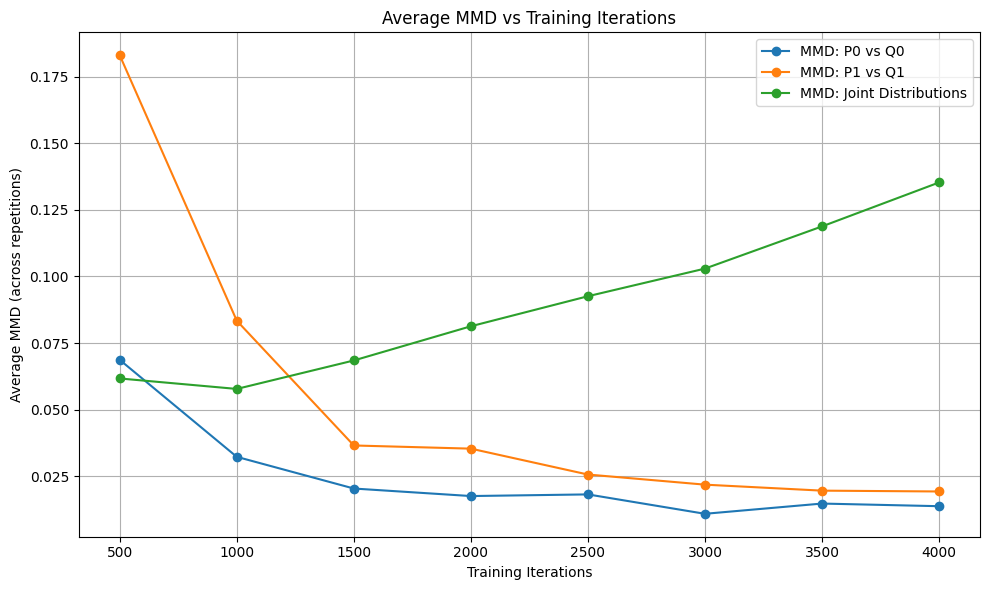

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


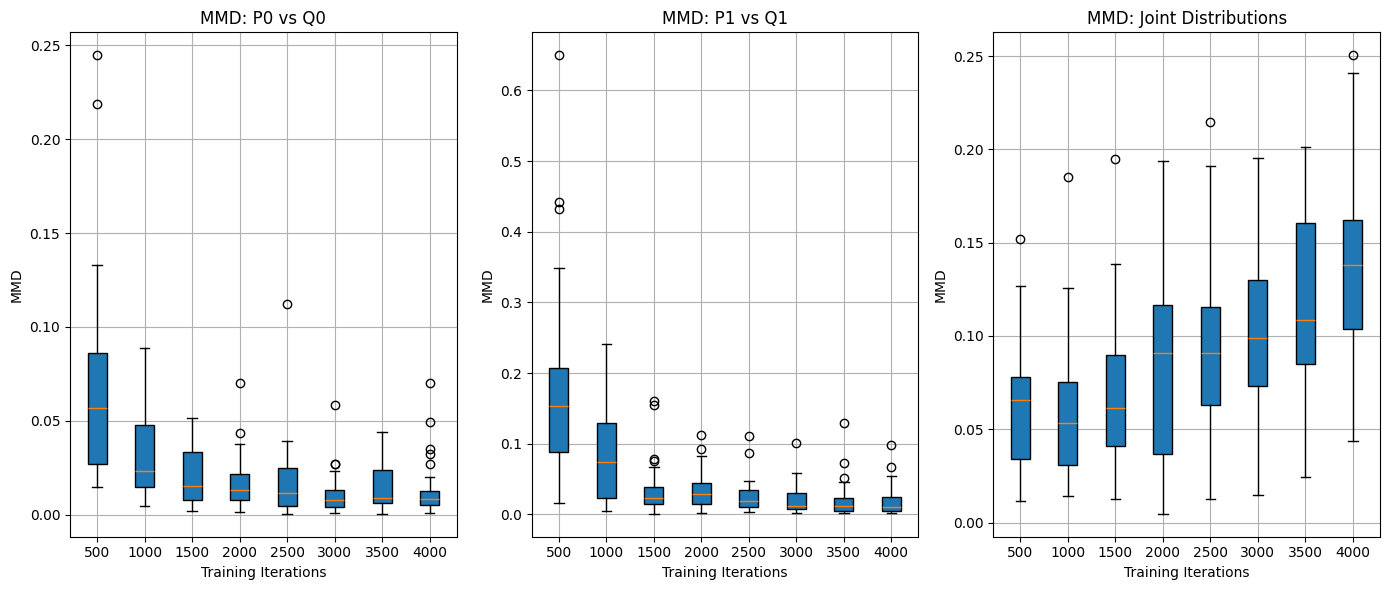

In [5]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


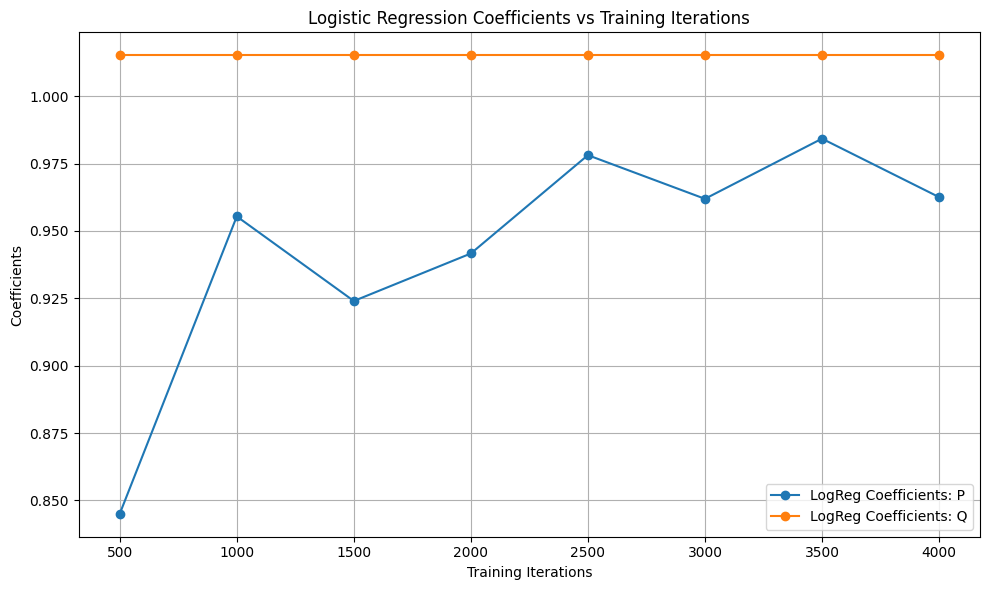

In [6]:
# Extract coefficients for each iteration
iterations = list(tracker.keys())
coeffs_p = [np.mean(tracker[iteration]["logreg_coeffs_p"], axis=0) for iteration in iterations]
coeffs_q = [np.mean(tracker[iteration]["logreg_coeffs_q"], axis=0) for iteration in iterations]

# Plot the coefficients
plt.figure(figsize=(10, 6))

# Logistic Regression Coefficients for P
plt.plot(iterations, np.squeeze(coeffs_p), marker='o', label='LogReg Coefficients: P')

# Logistic Regression Coefficients for Q
plt.plot(iterations, np.squeeze(coeffs_q), marker='o', label='LogReg Coefficients: Q')

# Customization
plt.title('Logistic Regression Coefficients vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Coefficients')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


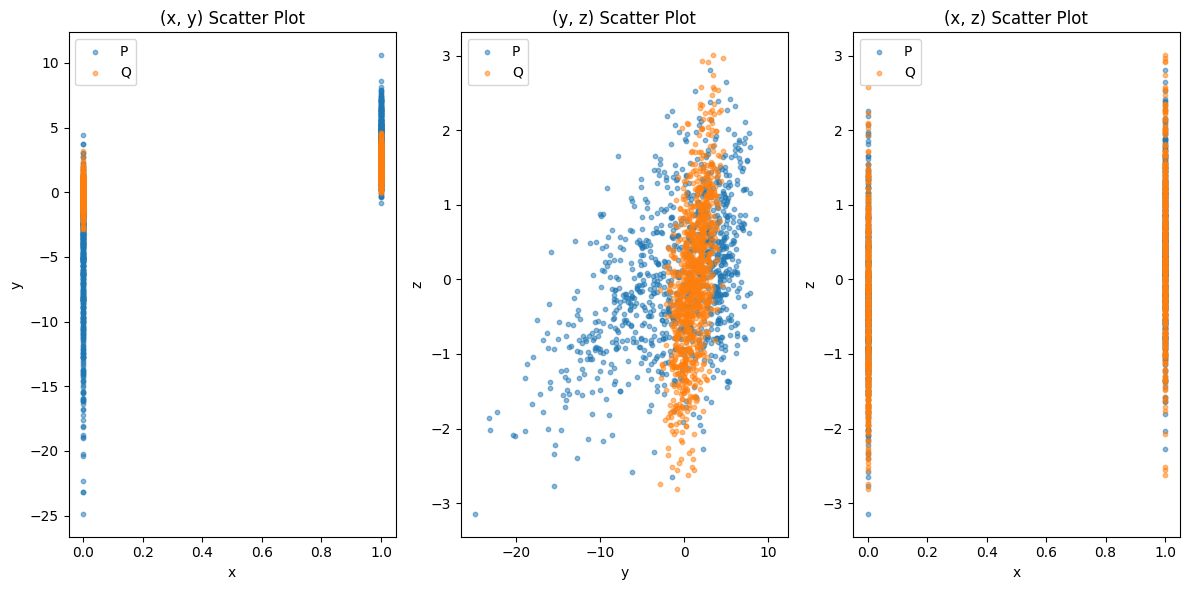

In [7]:
# Scatter plot for P and Q
plt.figure(figsize=(12, 6))

# (x, y) scatter for P and Q
plt.subplot(1, 3, 1)
plt.scatter(P_joint[:, 0], P_joint[:, 1], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 1], alpha=0.5, label='Q', s=10)
plt.title('(x, y) Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# (y, z) scatter for P and Q
plt.subplot(1, 3, 2)
plt.scatter(P_joint[:, 1], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 1], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(y, z) Scatter Plot')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

# (x, z) scatter for P and Q
plt.subplot(1, 3, 3)
plt.scatter(P_joint[:, 0], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(x, z) Scatter Plot')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

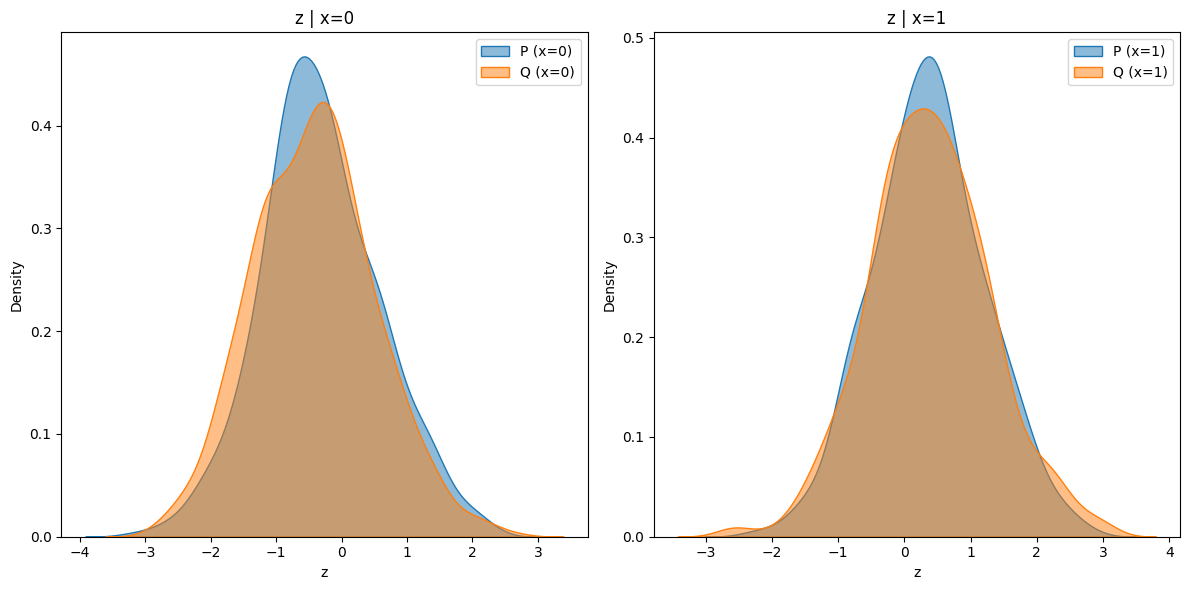

In [8]:
import seaborn as sns

# Separate z for x=0 and x=1
z_p_given_x0 = P_joint[P_joint[:, 0] == 0][:, 2]
z_p_given_x1 = P_joint[P_joint[:, 0] == 1][:, 2]
z_q_given_x0 = Q_joint[Q_joint[:, 0] == 0][:, 2]
z_q_given_x1 = Q_joint[Q_joint[:, 0] == 1][:, 2]

# KDE plots for z | x
plt.figure(figsize=(12, 6))

# z | x=0
plt.subplot(1, 2, 1)
sns.kdeplot(z_p_given_x0, label='P (x=0)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x0, label='Q (x=0)', fill=True, alpha=0.5)
plt.title('z | x=0')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

# z | x=1
plt.subplot(1, 2, 2)
sns.kdeplot(z_p_given_x1, label='P (x=1)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x1, label='Q (x=1)', fill=True, alpha=0.5)
plt.title('z | x=1')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

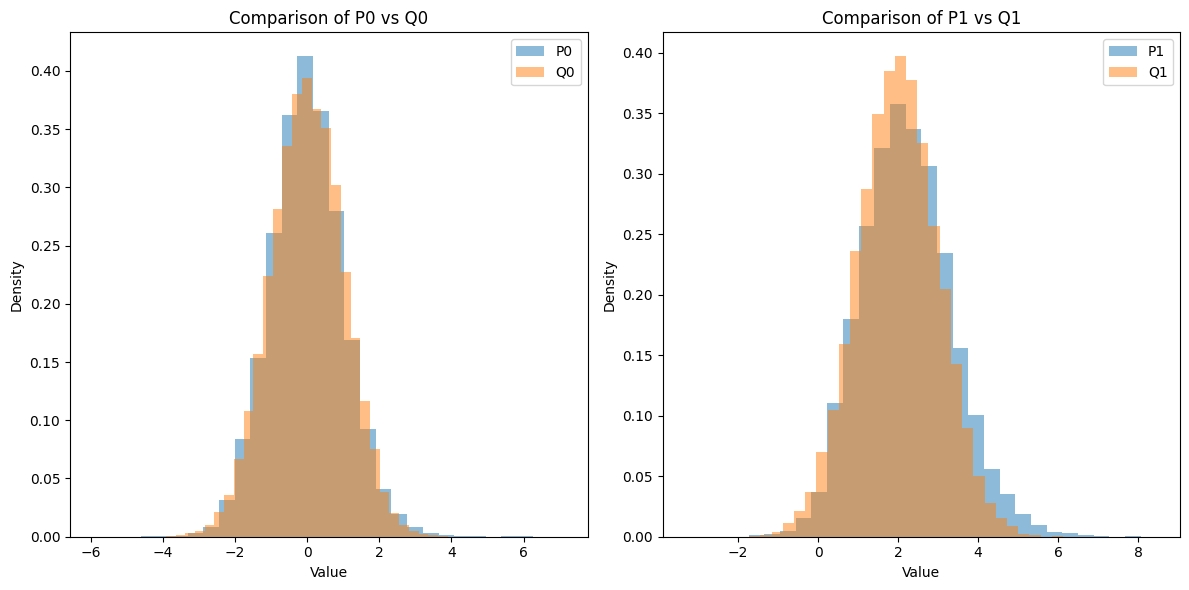

In [9]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## Introducing other variables

In [19]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 1
nX = 1
nO = 1
nS= 1
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.9244, loss1 1.9998, loss2 0.1509
Epoch 100: loss 1.3978, loss1 2.8025, loss2 2.8094
Epoch 200: loss 1.4001, loss1 2.7923, loss2 2.7844
Epoch 300: loss 1.4066, loss1 2.8016, loss2 2.7899
Epoch 400: loss 1.4121, loss1 2.8507, loss2 2.8772
Epoch 500: loss 1.3978, loss1 2.7757, loss2 2.7559
Epoch 1: loss 2.2835,	loss_y 1.5454, 1.5618, 0.0327,	loss_eta 0.7381, 0.7793, 0.0824
Epoch 100: loss 1.1746,	loss_y 0.6638, 1.7978, 2.2679,	loss_eta 0.5108, 1.1462, 1.2709
Epoch 200: loss 1.3109,	loss_y 0.6654, 1.0515, 0.7723,	loss_eta 0.6456, 0.9158, 0.5405
Epoch 300: loss 1.7513,	loss_y 1.0546, 2.2159, 2.3225,	loss_eta 0.6967, 1.0280, 0.6626
Epoch 400: loss 1.5823,	loss_y 0.8634, 2.0108, 2.2948,	loss_eta 0.7190, 1.2089, 0.9798
Epoch 500: loss 1.5482,	loss_y 0.8635, 1.2441, 0.7612,	loss_eta 0.6847, 0.8849, 0.4004
Epoch 1: loss 1.4249, loss1 2.8139, loss2 2.7780
Epoch 100: loss 1.3832, loss1 2.8077, loss2 2.8490
Epoch 200: loss 1.4034, loss1 2.8071, loss2 2.8075
Epoch 300: loss 1.3909, l

  3%|▎         | 1/30 [01:24<40:55, 84.68s/it]

Epoch 500: loss 0.9883,	loss_y 0.4168, 0.8606, 0.8877,	loss_eta 0.5715, 1.1146, 1.0862
Epoch 1: loss 1.9046, loss1 1.9964, loss2 0.1836
Epoch 100: loss 1.4085, loss1 2.7997, loss2 2.7824
Epoch 200: loss 1.4152, loss1 2.8186, loss2 2.8067
Epoch 300: loss 1.4043, loss1 2.7709, loss2 2.7331
Epoch 400: loss 1.4013, loss1 2.7849, loss2 2.7672
Epoch 500: loss 1.3652, loss1 2.7443, loss2 2.7583
Epoch 1: loss 2.3978,	loss_y 1.6359, 1.6557, 0.0396,	loss_eta 0.7619, 0.8083, 0.0928
Epoch 100: loss 1.3118,	loss_y 0.6350, 1.7643, 2.2584,	loss_eta 0.6768, 1.3479, 1.3422
Epoch 200: loss 1.4951,	loss_y 0.8296, 1.3233, 0.9874,	loss_eta 0.6655, 0.9038, 0.4766
Epoch 300: loss 1.2344,	loss_y 0.6260, 1.3772, 1.5024,	loss_eta 0.6084, 0.9325, 0.6482
Epoch 400: loss 1.4849,	loss_y 0.7161, 1.8899, 2.3476,	loss_eta 0.7688, 1.2685, 0.9994
Epoch 500: loss 1.4393,	loss_y 0.8057, 1.3337, 1.0561,	loss_eta 0.6336, 0.9927, 0.7183
Epoch 1: loss 1.4017, loss1 2.7874, loss2 2.7715
Epoch 100: loss 1.4303, loss1 2.7991, lo

  7%|▋         | 2/30 [02:38<36:31, 78.27s/it]

Epoch 500: loss 1.0532,	loss_y 0.4456, 0.9008, 0.9105,	loss_eta 0.6077, 1.1599, 1.1044
Epoch 1: loss 1.8293, loss1 1.9374, loss2 0.2161
Epoch 100: loss 1.3396, loss1 2.7066, loss2 2.7340
Epoch 200: loss 1.3822, loss1 2.7294, loss2 2.6945
Epoch 300: loss 1.3722, loss1 2.7224, loss2 2.7004
Epoch 400: loss 1.3529, loss1 2.6941, loss2 2.6823
Epoch 500: loss 1.3676, loss1 2.7109, loss2 2.6865
Epoch 1: loss 2.3016,	loss_y 1.5363, 1.5530, 0.0336,	loss_eta 0.7653, 0.7984, 0.0662
Epoch 100: loss 1.2960,	loss_y 0.7200, 1.9506, 2.4613,	loss_eta 0.5760, 1.1050, 1.0580
Epoch 200: loss 1.1602,	loss_y 0.5753, 0.9915, 0.8324,	loss_eta 0.5850, 1.1034, 1.0368
Epoch 300: loss 1.7772,	loss_y 1.1641, 1.8024, 1.2766,	loss_eta 0.6131, 1.1100, 0.9938
Epoch 400: loss 1.4800,	loss_y 0.8968, 2.2738, 2.7540,	loss_eta 0.5832, 1.0705, 0.9746
Epoch 500: loss 1.5336,	loss_y 0.7737, 1.2846, 1.0218,	loss_eta 0.7599, 1.5159, 1.5122
Epoch 1: loss 1.3739, loss1 2.7360, loss2 2.7243
Epoch 100: loss 1.3645, loss1 2.7341, lo

 10%|█         | 3/30 [03:46<33:07, 73.62s/it]

Epoch 500: loss 1.1284,	loss_y 0.4957, 0.9178, 0.8442,	loss_eta 0.6327, 0.9652, 0.6650
Epoch 1: loss 1.8133, loss1 1.9284, loss2 0.2304
Epoch 100: loss 1.3543, loss1 2.7153, loss2 2.7221
Epoch 200: loss 1.3683, loss1 2.6979, loss2 2.6593
Epoch 300: loss 1.3524, loss1 2.7026, loss2 2.7004
Epoch 400: loss 1.3567, loss1 2.6903, loss2 2.6670
Epoch 500: loss 1.3709, loss1 2.6961, loss2 2.6505
Epoch 1: loss 2.3948,	loss_y 1.6124, 1.6226, 0.0204,	loss_eta 0.7823, 0.8128, 0.0609
Epoch 100: loss 1.2772,	loss_y 0.6921, 1.8349, 2.2857,	loss_eta 0.5852, 1.1968, 1.2233
Epoch 200: loss 1.6518,	loss_y 0.8208, 1.1102, 0.5787,	loss_eta 0.8310, 1.0107, 0.3595
Epoch 300: loss 1.3598,	loss_y 0.6580, 1.2819, 1.2478,	loss_eta 0.7017, 0.8640, 0.3246
Epoch 400: loss 1.3891,	loss_y 0.7027, 1.7541, 2.1028,	loss_eta 0.6863, 0.8608, 0.3489
Epoch 500: loss 1.2863,	loss_y 0.6910, 1.7447, 2.1074,	loss_eta 0.5953, 0.9629, 0.7352
Epoch 1: loss 1.3649, loss1 2.7186, loss2 2.7073
Epoch 100: loss 1.3540, loss1 2.6823, lo

 13%|█▎        | 4/30 [04:49<30:08, 69.55s/it]

Epoch 500: loss 0.9990,	loss_y 0.4483, 0.8539, 0.8113,	loss_eta 0.5507, 1.1847, 1.2680
Epoch 1: loss 1.9012, loss1 1.9851, loss2 0.1677
Epoch 100: loss 1.3970, loss1 2.7980, loss2 2.8019
Epoch 200: loss 1.3834, loss1 2.7567, loss2 2.7466
Epoch 300: loss 1.3904, loss1 2.7651, loss2 2.7493
Epoch 400: loss 1.3995, loss1 2.7663, loss2 2.7337
Epoch 500: loss 1.4006, loss1 2.8128, loss2 2.8246
Epoch 1: loss 2.4184,	loss_y 1.6536, 1.6732, 0.0392,	loss_eta 0.7648, 0.7955, 0.0614
Epoch 100: loss 1.2595,	loss_y 0.6939, 1.8631, 2.3384,	loss_eta 0.5655, 1.2549, 1.3788
Epoch 200: loss 1.4351,	loss_y 0.8250, 1.2075, 0.7651,	loss_eta 0.6101, 0.9576, 0.6952
Epoch 300: loss 1.7548,	loss_y 1.0406, 2.0643, 2.0475,	loss_eta 0.7142, 1.1158, 0.8032
Epoch 400: loss 1.5458,	loss_y 0.7705, 2.0387, 2.5364,	loss_eta 0.7753, 1.1801, 0.8097
Epoch 500: loss 1.4591,	loss_y 0.7597, 1.3347, 1.1501,	loss_eta 0.6994, 0.8171, 0.2355
Epoch 1: loss 1.3826, loss1 2.7786, loss2 2.7920
Epoch 100: loss 1.3843, loss1 2.7814, lo

 17%|█▋        | 5/30 [05:54<28:12, 67.72s/it]

Epoch 500: loss 0.9940,	loss_y 0.4337, 0.8576, 0.8478,	loss_eta 0.5603, 1.1183, 1.1159
Epoch 1: loss 1.8980, loss1 1.9860, loss2 0.1761
Epoch 100: loss 1.3763, loss1 2.8095, loss2 2.8664
Epoch 200: loss 1.3824, loss1 2.7607, loss2 2.7565
Epoch 300: loss 1.3848, loss1 2.7433, loss2 2.7170
Epoch 400: loss 1.3917, loss1 2.7485, loss2 2.7137
Epoch 500: loss 1.3644, loss1 2.7581, loss2 2.7875
Epoch 1: loss 2.3064,	loss_y 1.5170, 1.5479, 0.0619,	loss_eta 0.7894, 0.8239, 0.0689
Epoch 100: loss 1.3417,	loss_y 0.7507, 1.9015, 2.3017,	loss_eta 0.5911, 1.1302, 1.0784
Epoch 200: loss 1.2828,	loss_y 0.6964, 1.0722, 0.7517,	loss_eta 0.5865, 0.9399, 0.7069
Epoch 300: loss 1.4889,	loss_y 0.8555, 1.4716, 1.2321,	loss_eta 0.6334, 0.9973, 0.7279
Epoch 400: loss 1.6999,	loss_y 0.9951, 2.2257, 2.4613,	loss_eta 0.7048, 0.9908, 0.5721
Epoch 500: loss 1.5309,	loss_y 0.8074, 1.4387, 1.2627,	loss_eta 0.7236, 0.8905, 0.3338
Epoch 1: loss 1.3948, loss1 2.7520, loss2 2.7143
Epoch 100: loss 1.3665, loss1 2.7470, lo

 20%|██        | 6/30 [07:01<26:57, 67.38s/it]

Epoch 500: loss 1.0493,	loss_y 0.4636, 0.9259, 0.9246,	loss_eta 0.5857, 1.1780, 1.1845
Epoch 1: loss 1.8503, loss1 1.9466, loss2 0.1926
Epoch 100: loss 1.3819, loss1 2.7545, loss2 2.7451
Epoch 200: loss 1.3521, loss1 2.7146, loss2 2.7249
Epoch 300: loss 1.3779, loss1 2.7536, loss2 2.7514
Epoch 400: loss 1.3761, loss1 2.7087, loss2 2.6652
Epoch 500: loss 1.3592, loss1 2.7168, loss2 2.7151
Epoch 1: loss 2.2431,	loss_y 1.5038, 1.5364, 0.0651,	loss_eta 0.7393, 0.7816, 0.0847
Epoch 100: loss 1.2421,	loss_y 0.6832, 1.8468, 2.3272,	loss_eta 0.5589, 0.9935, 0.8693
Epoch 200: loss 1.2672,	loss_y 0.7208, 1.1003, 0.7591,	loss_eta 0.5465, 1.0429, 0.9929
Epoch 300: loss 1.7190,	loss_y 1.0822, 1.9401, 1.7159,	loss_eta 0.6369, 1.0255, 0.7772
Epoch 400: loss 1.8398,	loss_y 1.0602, 2.4888, 2.8574,	loss_eta 0.7797, 1.3880, 1.2167
Epoch 500: loss 1.3421,	loss_y 0.7585, 1.4357, 1.3545,	loss_eta 0.5836, 1.0267, 0.8861
Epoch 1: loss 1.3839, loss1 2.7556, loss2 2.7433
Epoch 100: loss 1.3875, loss1 2.7580, lo

 23%|██▎       | 7/30 [08:43<30:12, 78.81s/it]

Epoch 500: loss 1.0319,	loss_y 0.4675, 1.0343, 1.1336,	loss_eta 0.5644, 1.1059, 1.0830
Epoch 1: loss 1.9053, loss1 1.9840, loss2 0.1574
Epoch 100: loss 1.4049, loss1 2.8207, loss2 2.8317
Epoch 200: loss 1.4214, loss1 2.7970, loss2 2.7512
Epoch 300: loss 1.4195, loss1 2.8363, loss2 2.8335
Epoch 400: loss 1.4328, loss1 2.8068, loss2 2.7481
Epoch 500: loss 1.4206, loss1 2.7922, loss2 2.7433
Epoch 1: loss 2.3547,	loss_y 1.5909, 1.6402, 0.0986,	loss_eta 0.7638, 0.7919, 0.0561
Epoch 100: loss 1.2804,	loss_y 0.6909, 1.8020, 2.2221,	loss_eta 0.5894, 1.2799, 1.3809
Epoch 200: loss 1.5617,	loss_y 0.8394, 1.1709, 0.6630,	loss_eta 0.7223, 0.8622, 0.2798
Epoch 300: loss 1.3516,	loss_y 0.7372, 1.7882, 2.1020,	loss_eta 0.6145, 0.9424, 0.6560
Epoch 400: loss 1.4698,	loss_y 0.8782, 2.2658, 2.7751,	loss_eta 0.5916, 1.3529, 1.5225
Epoch 500: loss 1.3914,	loss_y 0.7609, 1.8894, 2.2569,	loss_eta 0.6305, 0.8920, 0.5230
Epoch 1: loss 1.4069, loss1 2.7842, loss2 2.7547
Epoch 100: loss 1.3849, loss1 2.7506, lo

 27%|██▋       | 8/30 [09:47<27:14, 74.28s/it]

Epoch 500: loss 1.0101,	loss_y 0.4646, 0.9390, 0.9487,	loss_eta 0.5455, 1.2160, 1.3411
Epoch 1: loss 1.8673, loss1 1.9648, loss2 0.1949
Epoch 100: loss 1.3398, loss1 2.7484, loss2 2.8171
Epoch 200: loss 1.3531, loss1 2.7086, loss2 2.7109
Epoch 300: loss 1.3586, loss1 2.7043, loss2 2.6915
Epoch 400: loss 1.4049, loss1 2.7676, loss2 2.7254
Epoch 500: loss 1.3508, loss1 2.6827, loss2 2.6639
Epoch 1: loss 2.2132,	loss_y 1.4504, 1.4836, 0.0664,	loss_eta 0.7628, 0.8008, 0.0760
Epoch 100: loss 1.3414,	loss_y 0.7428, 1.9285, 2.3714,	loss_eta 0.5986, 1.2123, 1.2273
Epoch 200: loss 1.3523,	loss_y 0.5747, 0.9624, 0.7754,	loss_eta 0.7775, 0.8241, 0.0931
Epoch 300: loss 1.3609,	loss_y 0.5911, 1.2436, 1.3050,	loss_eta 0.7697, 0.8884, 0.2374
Epoch 400: loss 1.2718,	loss_y 0.5608, 1.3343, 1.5470,	loss_eta 0.7111, 1.0309, 0.6396
Epoch 500: loss 1.6307,	loss_y 0.9299, 1.5098, 1.1598,	loss_eta 0.7008, 0.8329, 0.2641
Epoch 1: loss 1.3683, loss1 2.7101, loss2 2.6835
Epoch 100: loss 1.3692, loss1 2.7323, lo

 30%|███       | 9/30 [10:51<24:49, 70.93s/it]

Epoch 500: loss 1.0969,	loss_y 0.4870, 0.8777, 0.7815,	loss_eta 0.6098, 1.0726, 0.9256
Epoch 1: loss 1.8584, loss1 1.9324, loss2 0.1479
Epoch 100: loss 1.3525, loss1 2.7208, loss2 2.7367
Epoch 200: loss 1.3539, loss1 2.7034, loss2 2.6990
Epoch 300: loss 1.3421, loss1 2.6946, loss2 2.7051
Epoch 400: loss 1.3717, loss1 2.7120, loss2 2.6807
Epoch 500: loss 1.3609, loss1 2.7207, loss2 2.7197
Epoch 1: loss 2.3111,	loss_y 1.5432, 1.5643, 0.0422,	loss_eta 0.7679, 0.8049, 0.0740
Epoch 100: loss 1.4027,	loss_y 0.7880, 1.9296, 2.2833,	loss_eta 0.6148, 1.1649, 1.1003
Epoch 200: loss 1.2739,	loss_y 0.5876, 1.1144, 1.0535,	loss_eta 0.6863, 1.0822, 0.7918
Epoch 300: loss 1.2001,	loss_y 0.5307, 0.9903, 0.9192,	loss_eta 0.6694, 1.1756, 1.0126
Epoch 400: loss 1.1465,	loss_y 0.6057, 1.1177, 1.0241,	loss_eta 0.5408, 1.0210, 0.9604
Epoch 500: loss 1.8552,	loss_y 1.2583, 1.5487, 0.5809,	loss_eta 0.5969, 0.8991, 0.6042
Epoch 1: loss 1.3614, loss1 2.7135, loss2 2.7041
Epoch 100: loss 1.3443, loss1 2.6860, lo

 33%|███▎      | 10/30 [11:55<22:56, 68.83s/it]

Epoch 500: loss 1.0232,	loss_y 0.4516, 0.9092, 0.9152,	loss_eta 0.5716, 1.1419, 1.1405
Epoch 1: loss 1.8610, loss1 1.9614, loss2 0.2007
Epoch 100: loss 1.3595, loss1 2.7409, loss2 2.7628
Epoch 200: loss 1.4110, loss1 2.7492, loss2 2.6764
Epoch 300: loss 1.3552, loss1 2.7425, loss2 2.7746
Epoch 400: loss 1.3566, loss1 2.7423, loss2 2.7715
Epoch 500: loss 1.3872, loss1 2.7767, loss2 2.7790
Epoch 1: loss 2.2840,	loss_y 1.5636, 1.5745, 0.0217,	loss_eta 0.7204, 0.7659, 0.0908
Epoch 100: loss 1.2988,	loss_y 0.6989, 1.6517, 1.9055,	loss_eta 0.5999, 1.2563, 1.3128
Epoch 200: loss 1.4215,	loss_y 0.6656, 1.1086, 0.8861,	loss_eta 0.7559, 0.9698, 0.4279
Epoch 300: loss 1.4349,	loss_y 0.7490, 1.5034, 1.5087,	loss_eta 0.6859, 0.8231, 0.2745
Epoch 400: loss 1.4365,	loss_y 0.8314, 1.5392, 1.4157,	loss_eta 0.6051, 0.9388, 0.6673
Epoch 500: loss 1.6683,	loss_y 0.9214, 1.7902, 1.7376,	loss_eta 0.7470, 1.7768, 2.0596
Epoch 1: loss 1.3918, loss1 2.7816, loss2 2.7795
Epoch 100: loss 1.4244, loss1 2.7948, lo

 37%|███▋      | 11/30 [13:00<21:23, 67.58s/it]

Epoch 500: loss 1.0068,	loss_y 0.4422, 0.8792, 0.8739,	loss_eta 0.5646, 1.1677, 1.2062
Epoch 1: loss 1.8664, loss1 1.9550, loss2 0.1772
Epoch 100: loss 1.3854, loss1 2.7823, loss2 2.7938
Epoch 200: loss 1.3710, loss1 2.7563, loss2 2.7705
Epoch 300: loss 1.3745, loss1 2.7538, loss2 2.7585
Epoch 400: loss 1.3787, loss1 2.7608, loss2 2.7643
Epoch 500: loss 1.4151, loss1 2.7802, loss2 2.7303
Epoch 1: loss 2.4160,	loss_y 1.6543, 1.6593, 0.0101,	loss_eta 0.7617, 0.8080, 0.0926
Epoch 100: loss 1.2624,	loss_y 0.7228, 1.8067, 2.1678,	loss_eta 0.5396, 1.1789, 1.2786
Epoch 200: loss 1.3118,	loss_y 0.5559, 0.9555, 0.7994,	loss_eta 0.7559, 0.8687, 0.2256
Epoch 300: loss 1.6230,	loss_y 0.9318, 1.6763, 1.4890,	loss_eta 0.6912, 0.8798, 0.3772
Epoch 400: loss 1.4430,	loss_y 0.7937, 1.7679, 1.9484,	loss_eta 0.6493, 0.9704, 0.6422
Epoch 500: loss 1.7096,	loss_y 1.0944, 2.3122, 2.4357,	loss_eta 0.6152, 1.1513, 1.0723
Epoch 1: loss 1.3886, loss1 2.7832, loss2 2.7892
Epoch 100: loss 1.3385, loss1 2.7068, lo

 40%|████      | 12/30 [14:07<20:15, 67.52s/it]

Epoch 500: loss 1.0108,	loss_y 0.4517, 0.8955, 0.8876,	loss_eta 0.5591, 1.1340, 1.1497
Epoch 1: loss 1.8524, loss1 1.9598, loss2 0.2149
Epoch 100: loss 1.3923, loss1 2.7894, loss2 2.7943
Epoch 200: loss 1.3722, loss1 2.7424, loss2 2.7404
Epoch 300: loss 1.4140, loss1 2.7574, loss2 2.6866
Epoch 400: loss 1.3666, loss1 2.7492, loss2 2.7651
Epoch 500: loss 1.3963, loss1 2.7667, loss2 2.7409
Epoch 1: loss 2.2714,	loss_y 1.5311, 1.5763, 0.0904,	loss_eta 0.7403, 0.7909, 0.1012
Epoch 100: loss 1.4135,	loss_y 0.8058, 2.0076, 2.4037,	loss_eta 0.6078, 0.9704, 0.7252
Epoch 200: loss 1.2767,	loss_y 0.6894, 1.0548, 0.7309,	loss_eta 0.5873, 0.9092, 0.6437
Epoch 300: loss 1.6788,	loss_y 1.0590, 1.7122, 1.3065,	loss_eta 0.6199, 1.1032, 0.9666
Epoch 400: loss 1.7713,	loss_y 0.9894, 2.4304, 2.8820,	loss_eta 0.7819, 1.2382, 0.9126
Epoch 500: loss 1.4312,	loss_y 0.7475, 1.5004, 1.5059,	loss_eta 0.6837, 0.9321, 0.4967
Epoch 1: loss 1.3799, loss1 2.7241, loss2 2.6884
Epoch 100: loss 1.3934, loss1 2.7427, lo

 43%|████▎     | 13/30 [15:13<18:59, 67.02s/it]

Epoch 500: loss 1.0213,	loss_y 0.4526, 0.9600, 1.0147,	loss_eta 0.5687, 1.1383, 1.1393
Epoch 1: loss 1.9111, loss1 1.9912, loss2 0.1602
Epoch 100: loss 1.4067, loss1 2.8093, loss2 2.8051
Epoch 200: loss 1.3917, loss1 2.7879, loss2 2.7923
Epoch 300: loss 1.3914, loss1 2.7865, loss2 2.7903
Epoch 400: loss 1.3585, loss1 2.7601, loss2 2.8033
Epoch 500: loss 1.3939, loss1 2.7889, loss2 2.7900
Epoch 1: loss 2.3188,	loss_y 1.5612, 1.5986, 0.0746,	loss_eta 0.7576, 0.7929, 0.0707
Epoch 100: loss 1.3159,	loss_y 0.7265, 1.8578, 2.2627,	loss_eta 0.5894, 1.1187, 1.0586
Epoch 200: loss 1.4140,	loss_y 0.6752, 1.0589, 0.7674,	loss_eta 0.7389, 1.0476, 0.6175
Epoch 300: loss 1.5775,	loss_y 0.8998, 1.7139, 1.6282,	loss_eta 0.6778, 1.0233, 0.6911
Epoch 400: loss 1.5083,	loss_y 0.8485, 2.0953, 2.4937,	loss_eta 0.6599, 0.8822, 0.4447
Epoch 500: loss 1.3009,	loss_y 0.7346, 2.1998, 2.9304,	loss_eta 0.5664, 0.8788, 0.6250
Epoch 1: loss 1.4058, loss1 2.7991, loss2 2.7867
Epoch 100: loss 1.3848, loss1 2.8001, lo

 47%|████▋     | 14/30 [16:18<17:41, 66.34s/it]

Epoch 500: loss 0.9953,	loss_y 0.4267, 0.9039, 0.9544,	loss_eta 0.5686, 1.1873, 1.2373
Epoch 1: loss 1.8734, loss1 1.9623, loss2 0.1779
Epoch 100: loss 1.3830, loss1 2.7700, loss2 2.7740
Epoch 200: loss 1.3857, loss1 2.7517, loss2 2.7320
Epoch 300: loss 1.4015, loss1 2.7753, loss2 2.7476
Epoch 400: loss 1.3710, loss1 2.7576, loss2 2.7734
Epoch 500: loss 1.3533, loss1 2.7411, loss2 2.7756
Epoch 1: loss 2.2847,	loss_y 1.5266, 1.5338, 0.0146,	loss_eta 0.7581, 0.8006, 0.0849
Epoch 100: loss 1.3296,	loss_y 0.7380, 1.4763, 1.4767,	loss_eta 0.5916, 0.9192, 0.6552
Epoch 200: loss 1.2361,	loss_y 0.6528, 1.4740, 1.6425,	loss_eta 0.5834, 1.4370, 1.7073
Epoch 300: loss 1.5067,	loss_y 0.8123, 1.2462, 0.8677,	loss_eta 0.6944, 0.8659, 0.3432
Epoch 400: loss 1.2458,	loss_y 0.6654, 0.9366, 0.5425,	loss_eta 0.5804, 1.1029, 1.0450
Epoch 500: loss 1.3012,	loss_y 0.6158, 1.3467, 1.4618,	loss_eta 0.6854, 1.8220, 2.2732
Epoch 1: loss 1.3694, loss1 2.7400, loss2 2.7412
Epoch 100: loss 1.3602, loss1 2.7347, lo

 50%|█████     | 15/30 [17:23<16:27, 65.84s/it]

Epoch 500: loss 1.0222,	loss_y 0.4525, 0.9799, 1.0548,	loss_eta 0.5697, 1.1984, 1.2574
Epoch 1: loss 1.8746, loss1 1.9677, loss2 0.1862
Epoch 100: loss 1.3917, loss1 2.7478, loss2 2.7122
Epoch 200: loss 1.3585, loss1 2.7455, loss2 2.7739
Epoch 300: loss 1.3767, loss1 2.7561, loss2 2.7588
Epoch 400: loss 1.3634, loss1 2.7336, loss2 2.7405
Epoch 500: loss 1.4045, loss1 2.7504, loss2 2.6917
Epoch 1: loss 2.3236,	loss_y 1.5866, 1.6115, 0.0497,	loss_eta 0.7370, 0.7935, 0.1129
Epoch 100: loss 1.3224,	loss_y 0.7459, 1.9049, 2.3178,	loss_eta 0.5764, 0.9638, 0.7747
Epoch 200: loss 1.3406,	loss_y 0.5771, 1.0892, 1.0243,	loss_eta 0.7635, 1.2559, 0.9848
Epoch 300: loss 1.4459,	loss_y 0.6656, 1.2441, 1.1571,	loss_eta 0.7803, 1.2085, 0.8562
Epoch 400: loss 2.0268,	loss_y 1.4179, 2.6105, 2.3852,	loss_eta 0.6089, 0.9284, 0.6389
Epoch 500: loss 2.0301,	loss_y 1.3215, 2.0192, 1.3954,	loss_eta 0.7087, 1.0409, 0.6645
Epoch 1: loss 1.4091, loss1 2.7563, loss2 2.6944
Epoch 100: loss 1.3813, loss1 2.7638, lo

 53%|█████▎    | 16/30 [18:28<15:20, 65.72s/it]

Epoch 500: loss 1.0724,	loss_y 0.4854, 0.9265, 0.8823,	loss_eta 0.5870, 1.1660, 1.1579
Epoch 1: loss 1.8807, loss1 1.9741, loss2 0.1867
Epoch 100: loss 1.3476, loss1 2.7479, loss2 2.8006
Epoch 200: loss 1.3503, loss1 2.7255, loss2 2.7503
Epoch 300: loss 1.3701, loss1 2.7533, loss2 2.7663
Epoch 400: loss 1.3890, loss1 2.7670, loss2 2.7558
Epoch 500: loss 1.3588, loss1 2.7481, loss2 2.7785
Epoch 1: loss 2.2851,	loss_y 1.4953, 1.5163, 0.0420,	loss_eta 0.7898, 0.8145, 0.0495
Epoch 100: loss 1.2330,	loss_y 0.6688, 1.7357, 2.1338,	loss_eta 0.5642, 1.1304, 1.1325
Epoch 200: loss 1.3057,	loss_y 0.5917, 0.9074, 0.6316,	loss_eta 0.7140, 0.8614, 0.2947
Epoch 300: loss 1.2527,	loss_y 0.5811, 1.3616, 1.5610,	loss_eta 0.6716, 0.8163, 0.2894
Epoch 400: loss 1.2865,	loss_y 0.6843, 1.7318, 2.0950,	loss_eta 0.6022, 0.9134, 0.6225
Epoch 500: loss 1.1746,	loss_y 0.6037, 1.4558, 1.7043,	loss_eta 0.5710, 1.2373, 1.3326
Epoch 1: loss 1.4249, loss1 2.7948, loss2 2.7397
Epoch 100: loss 1.3620, loss1 2.7529, lo

 57%|█████▋    | 17/30 [19:33<14:09, 65.34s/it]

Epoch 500: loss 1.0306,	loss_y 0.4346, 0.8931, 0.9170,	loss_eta 0.5960, 1.2162, 1.2404
Epoch 1: loss 1.8588, loss1 1.9557, loss2 0.1939
Epoch 100: loss 1.3766, loss1 2.7465, loss2 2.7399
Epoch 200: loss 1.3542, loss1 2.6862, loss2 2.6641
Epoch 300: loss 1.3541, loss1 2.7159, loss2 2.7237
Epoch 400: loss 1.3488, loss1 2.7266, loss2 2.7555
Epoch 500: loss 1.3726, loss1 2.7360, loss2 2.7270
Epoch 1: loss 2.2036,	loss_y 1.4630, 1.4829, 0.0398,	loss_eta 0.7405, 0.7796, 0.0781
Epoch 100: loss 1.3701,	loss_y 0.5519, 1.5030, 1.9021,	loss_eta 0.8182, 1.5350, 1.4336
Epoch 200: loss 1.3710,	loss_y 0.5757, 1.1270, 1.1026,	loss_eta 0.7953, 0.9844, 0.3782
Epoch 300: loss 1.5606,	loss_y 0.9107, 1.1535, 0.4857,	loss_eta 0.6499, 0.9487, 0.5976
Epoch 400: loss 1.4897,	loss_y 0.8713, 1.9442, 2.1458,	loss_eta 0.6184, 1.3629, 1.4889
Epoch 500: loss 1.3317,	loss_y 0.7461, 1.2584, 1.0247,	loss_eta 0.5856, 1.0820, 0.9928
Epoch 1: loss 1.3593, loss1 2.7375, loss2 2.7564
Epoch 100: loss 1.3830, loss1 2.7586, lo

 60%|██████    | 18/30 [20:36<12:58, 64.88s/it]

Epoch 500: loss 0.9717,	loss_y 0.4154, 0.8421, 0.8534,	loss_eta 0.5563, 1.1208, 1.1289
Epoch 1: loss 1.8747, loss1 1.9642, loss2 0.1790
Epoch 100: loss 1.4020, loss1 2.7831, loss2 2.7623
Epoch 200: loss 1.3533, loss1 2.7192, loss2 2.7317
Epoch 300: loss 1.3980, loss1 2.7470, loss2 2.6978
Epoch 400: loss 1.3710, loss1 2.7577, loss2 2.7733
Epoch 500: loss 1.3804, loss1 2.7463, loss2 2.7317
Epoch 1: loss 2.3816,	loss_y 1.5930, 1.6030, 0.0200,	loss_eta 0.7886, 0.8172, 0.0573
Epoch 100: loss 1.2408,	loss_y 0.6566, 1.7143, 2.1155,	loss_eta 0.5842, 1.0991, 1.0298
Epoch 200: loss 1.4665,	loss_y 0.8173, 1.4642, 1.2939,	loss_eta 0.6493, 0.8693, 0.4401
Epoch 300: loss 1.2577,	loss_y 0.6126, 1.0872, 0.9492,	loss_eta 0.6451, 0.9062, 0.5224
Epoch 400: loss 1.6833,	loss_y 0.9729, 1.9935, 2.0412,	loss_eta 0.7104, 1.2138, 1.0068
Epoch 500: loss 1.5407,	loss_y 0.8206, 1.6121, 1.5830,	loss_eta 0.7201, 0.8289, 0.2176
Epoch 1: loss 1.3960, loss1 2.7475, loss2 2.7030
Epoch 100: loss 1.3885, loss1 2.7348, lo

 63%|██████▎   | 19/30 [21:43<11:58, 65.35s/it]

Epoch 500: loss 1.0031,	loss_y 0.4514, 0.9387, 0.9745,	loss_eta 0.5517, 1.1336, 1.1639
Epoch 1: loss 1.8868, loss1 1.9754, loss2 0.1772
Epoch 100: loss 1.3753, loss1 2.7706, loss2 2.7905
Epoch 200: loss 1.3851, loss1 2.7731, loss2 2.7758
Epoch 300: loss 1.3765, loss1 2.7662, loss2 2.7793
Epoch 400: loss 1.3876, loss1 2.7778, loss2 2.7804
Epoch 500: loss 1.3901, loss1 2.7563, loss2 2.7322
Epoch 1: loss 2.4454,	loss_y 1.6523, 1.6766, 0.0485,	loss_eta 0.7931, 0.8345, 0.0830
Epoch 100: loss 1.4067,	loss_y 0.7945, 1.9276, 2.2660,	loss_eta 0.6122, 0.9623, 0.7002
Epoch 200: loss 1.3633,	loss_y 0.7837, 1.2687, 0.9701,	loss_eta 0.5796, 1.1444, 1.1294
Epoch 300: loss 1.2968,	loss_y 0.5591, 1.2035, 1.2889,	loss_eta 0.7377, 1.1420, 0.8086
Epoch 400: loss 1.2658,	loss_y 0.6722, 1.3571, 1.3698,	loss_eta 0.5936, 0.8781, 0.5689
Epoch 500: loss 1.6903,	loss_y 1.0890, 1.3178, 0.4576,	loss_eta 0.6014, 1.0387, 0.8746
Epoch 1: loss 1.3813, loss1 2.7695, loss2 2.7764
Epoch 100: loss 1.4000, loss1 2.7852, lo

 67%|██████▋   | 20/30 [22:48<10:52, 65.23s/it]

Epoch 500: loss 0.9765,	loss_y 0.4157, 0.8632, 0.8950,	loss_eta 0.5608, 1.1540, 1.1863
Epoch 1: loss 1.9075, loss1 1.9799, loss2 0.1449
Epoch 100: loss 1.3813, loss1 2.7776, loss2 2.7927
Epoch 200: loss 1.3972, loss1 2.7760, loss2 2.7577
Epoch 300: loss 1.3464, loss1 2.7579, loss2 2.8229
Epoch 400: loss 1.4133, loss1 2.7635, loss2 2.7004
Epoch 500: loss 1.4228, loss1 2.8039, loss2 2.7622
Epoch 1: loss 2.2035,	loss_y 1.4791, 1.4990, 0.0399,	loss_eta 0.7244, 0.7684, 0.0880
Epoch 100: loss 1.3721,	loss_y 0.7617, 1.4268, 1.3302,	loss_eta 0.6104, 0.9629, 0.7051
Epoch 200: loss 1.1886,	loss_y 0.6330, 1.5759, 1.8857,	loss_eta 0.5556, 1.1787, 1.2462
Epoch 300: loss 1.1532,	loss_y 0.5565, 1.0432, 0.9734,	loss_eta 0.5967, 1.2302, 1.2671
Epoch 400: loss 1.2040,	loss_y 0.5521, 0.8678, 0.6312,	loss_eta 0.6518, 0.9662, 0.6287
Epoch 500: loss 1.2105,	loss_y 0.6134, 1.2076, 1.1884,	loss_eta 0.5971, 1.1781, 1.1621
Epoch 1: loss 1.3886, loss1 2.7945, loss2 2.8118
Epoch 100: loss 1.4264, loss1 2.8011, lo

 70%|███████   | 21/30 [24:03<10:13, 68.17s/it]

Epoch 500: loss 0.9723,	loss_y 0.4261, 0.8965, 0.9407,	loss_eta 0.5462, 1.1609, 1.2295
Epoch 1: loss 1.8829, loss1 1.9830, loss2 0.2003
Epoch 100: loss 1.3767, loss1 2.7867, loss2 2.8200
Epoch 200: loss 1.3877, loss1 2.7301, loss2 2.6847
Epoch 300: loss 1.3768, loss1 2.7495, loss2 2.7453
Epoch 400: loss 1.3680, loss1 2.7342, loss2 2.7324
Epoch 500: loss 1.3663, loss1 2.7517, loss2 2.7708
Epoch 1: loss 2.3194,	loss_y 1.5429, 1.5598, 0.0337,	loss_eta 0.7765, 0.8170, 0.0809
Epoch 100: loss 1.4312,	loss_y 0.8073, 2.0646, 2.5146,	loss_eta 0.6238, 1.1693, 1.0909
Epoch 200: loss 1.3375,	loss_y 0.6338, 0.9824, 0.6971,	loss_eta 0.7036, 0.8567, 0.3062
Epoch 300: loss 1.3114,	loss_y 0.6350, 1.3562, 1.4425,	loss_eta 0.6764, 0.8618, 0.3708
Epoch 400: loss 1.4236,	loss_y 0.7808, 1.8903, 2.2191,	loss_eta 0.6429, 0.9767, 0.6676
Epoch 500: loss 1.4220,	loss_y 0.7910, 1.7515, 1.9210,	loss_eta 0.6310, 1.1109, 0.9598
Epoch 1: loss 1.3566, loss1 2.7236, loss2 2.7338
Epoch 100: loss 1.3792, loss1 2.7473, lo

 73%|███████▎  | 22/30 [25:09<09:01, 67.66s/it]

Epoch 500: loss 1.0572,	loss_y 0.4599, 0.8559, 0.7921,	loss_eta 0.5973, 1.1530, 1.1113
Epoch 1: loss 1.8717, loss1 1.9500, loss2 0.1565
Epoch 100: loss 1.3623, loss1 2.7109, loss2 2.6971
Epoch 200: loss 1.3480, loss1 2.7418, loss2 2.7878
Epoch 300: loss 1.3961, loss1 2.7596, loss2 2.7271
Epoch 400: loss 1.3941, loss1 2.7395, loss2 2.6908
Epoch 500: loss 1.3484, loss1 2.7258, loss2 2.7548
Epoch 1: loss 2.3578,	loss_y 1.6011, 1.6378, 0.0734,	loss_eta 0.7567, 0.7982, 0.0831
Epoch 100: loss 1.2846,	loss_y 0.7230, 1.7779, 2.1099,	loss_eta 0.5616, 1.1711, 1.2189
Epoch 200: loss 1.4097,	loss_y 0.6026, 0.9724, 0.7397,	loss_eta 0.8072, 0.9132, 0.2121
Epoch 300: loss 1.2916,	loss_y 0.5750, 1.3416, 1.5331,	loss_eta 0.7166, 0.8353, 0.2376
Epoch 400: loss 1.5638,	loss_y 0.9893, 1.8726, 1.7666,	loss_eta 0.5745, 0.8718, 0.5946
Epoch 500: loss 1.7089,	loss_y 1.0429, 1.5484, 1.0110,	loss_eta 0.6660, 1.2529, 1.1738
Epoch 1: loss 1.3486, loss1 2.7192, loss2 2.7413
Epoch 100: loss 1.3693, loss1 2.7329, lo

 77%|███████▋  | 23/30 [26:27<08:13, 70.55s/it]

Epoch 500: loss 0.9737,	loss_y 0.4285, 0.8393, 0.8217,	loss_eta 0.5452, 1.1598, 1.2292
Epoch 1: loss 1.8647, loss1 1.9492, loss2 0.1689
Epoch 100: loss 1.3510, loss1 2.7337, loss2 2.7654
Epoch 200: loss 1.3700, loss1 2.7487, loss2 2.7575
Epoch 300: loss 1.3633, loss1 2.6964, loss2 2.6663
Epoch 400: loss 1.3651, loss1 2.7498, loss2 2.7695
Epoch 500: loss 1.3927, loss1 2.7537, loss2 2.7219
Epoch 1: loss 2.2572,	loss_y 1.4929, 1.5076, 0.0294,	loss_eta 0.7643, 0.7951, 0.0616
Epoch 100: loss 1.2870,	loss_y 0.6902, 1.6587, 1.9371,	loss_eta 0.5968, 1.0978, 1.0019
Epoch 200: loss 1.7683,	loss_y 1.1410, 1.7351, 1.1881,	loss_eta 0.6273, 0.9710, 0.6874
Epoch 300: loss 1.6814,	loss_y 1.0261, 2.0392, 2.0263,	loss_eta 0.6553, 0.7758, 0.2410
Epoch 400: loss 1.6811,	loss_y 0.9580, 1.4609, 1.0060,	loss_eta 0.7232, 0.9835, 0.5207
Epoch 500: loss 1.4125,	loss_y 0.7373, 1.5688, 1.6630,	loss_eta 0.6752, 0.9278, 0.5052
Epoch 1: loss 1.4080, loss1 2.7776, loss2 2.7393
Epoch 100: loss 1.3461, loss1 2.6922, lo

 80%|████████  | 24/30 [27:31<06:51, 68.65s/it]

Epoch 500: loss 1.0045,	loss_y 0.4056, 0.8515, 0.8916,	loss_eta 0.5989, 1.1362, 1.0747
Epoch 1: loss 1.8631, loss1 1.9646, loss2 0.2031
Epoch 100: loss 1.3762, loss1 2.7579, loss2 2.7633
Epoch 200: loss 1.3823, loss1 2.7397, loss2 2.7148
Epoch 300: loss 1.3980, loss1 2.7686, loss2 2.7412
Epoch 400: loss 1.3542, loss1 2.7354, loss2 2.7624
Epoch 500: loss 1.3529, loss1 2.7422, loss2 2.7786
Epoch 1: loss 2.3041,	loss_y 1.5303, 1.5445, 0.0285,	loss_eta 0.7739, 0.7981, 0.0485
Epoch 100: loss 1.2439,	loss_y 0.6900, 1.8510, 2.3219,	loss_eta 0.5539, 1.2083, 1.3088
Epoch 200: loss 1.7783,	loss_y 1.0215, 1.3183, 0.5937,	loss_eta 0.7568, 0.9341, 0.3546
Epoch 300: loss 1.8053,	loss_y 1.1395, 2.3636, 2.4480,	loss_eta 0.6657, 0.8789, 0.4264
Epoch 400: loss 1.6593,	loss_y 1.0268, 1.7204, 1.3872,	loss_eta 0.6325, 1.0940, 0.9229
Epoch 500: loss 1.2168,	loss_y 0.6225, 1.4376, 1.6302,	loss_eta 0.5943, 1.3705, 1.5525
Epoch 1: loss 1.3846, loss1 2.7387, loss2 2.7082
Epoch 100: loss 1.3603, loss1 2.7497, lo

 83%|████████▎ | 25/30 [28:35<05:36, 67.21s/it]

Epoch 500: loss 1.0217,	loss_y 0.4273, 0.8479, 0.8414,	loss_eta 0.5945, 1.1599, 1.1309
Epoch 1: loss 1.8660, loss1 1.9740, loss2 0.2160
Epoch 100: loss 1.3868, loss1 2.7797, loss2 2.7858
Epoch 200: loss 1.3656, loss1 2.7597, loss2 2.7882
Epoch 300: loss 1.4124, loss1 2.7771, loss2 2.7294
Epoch 400: loss 1.4226, loss1 2.7913, loss2 2.7374
Epoch 500: loss 1.4028, loss1 2.7782, loss2 2.7507
Epoch 1: loss 2.3448,	loss_y 1.5640, 1.5857, 0.0433,	loss_eta 0.7808, 0.8146, 0.0676
Epoch 100: loss 1.2653,	loss_y 0.6646, 1.7231, 2.1171,	loss_eta 0.6007, 1.2257, 1.2500
Epoch 200: loss 1.3311,	loss_y 0.5429, 0.8071, 0.5284,	loss_eta 0.7882, 0.9969, 0.4174
Epoch 300: loss 1.3406,	loss_y 0.7227, 1.6718, 1.8981,	loss_eta 0.6178, 0.8356, 0.4354
Epoch 400: loss 1.3770,	loss_y 0.7433, 1.3347, 1.1829,	loss_eta 0.6338, 0.9518, 0.6361
Epoch 500: loss 1.3259,	loss_y 0.7487, 1.9894, 2.4813,	loss_eta 0.5772, 1.1825, 1.2106
Epoch 1: loss 1.3684, loss1 2.7583, loss2 2.7797
Epoch 100: loss 1.4055, loss1 2.7858, lo

 87%|████████▋ | 26/30 [29:55<04:44, 71.08s/it]

Epoch 500: loss 1.0555,	loss_y 0.5149, 1.0019, 0.9739,	loss_eta 0.5406, 1.1218, 1.1625
Epoch 1: loss 1.8834, loss1 1.9846, loss2 0.2024
Epoch 100: loss 1.3648, loss1 2.7716, loss2 2.8135
Epoch 200: loss 1.3885, loss1 2.7512, loss2 2.7255
Epoch 300: loss 1.3723, loss1 2.7350, loss2 2.7252
Epoch 400: loss 1.4000, loss1 2.7966, loss2 2.7932
Epoch 500: loss 1.3692, loss1 2.7618, loss2 2.7851
Epoch 1: loss 2.2754,	loss_y 1.4848, 1.4968, 0.0239,	loss_eta 0.7905, 0.8188, 0.0564
Epoch 100: loss 1.2401,	loss_y 0.6718, 1.8934, 2.4433,	loss_eta 0.5683, 1.1502, 1.1637
Epoch 200: loss 1.4646,	loss_y 0.8781, 1.2777, 0.7992,	loss_eta 0.5865, 0.9933, 0.8135
Epoch 300: loss 1.4728,	loss_y 0.8662, 1.9296, 2.1269,	loss_eta 0.6066, 0.9381, 0.6630
Epoch 400: loss 1.7036,	loss_y 0.8551, 2.0848, 2.4593,	loss_eta 0.8485, 1.2997, 0.9024
Epoch 500: loss 1.4031,	loss_y 0.7114, 1.4592, 1.4957,	loss_eta 0.6917, 0.8160, 0.2486
Epoch 1: loss 1.4040, loss1 2.7793, loss2 2.7507
Epoch 100: loss 1.3822, loss1 2.7942, lo

 90%|█████████ | 27/30 [31:12<03:39, 73.08s/it]

Epoch 500: loss 1.0465,	loss_y 0.5179, 0.9127, 0.7895,	loss_eta 0.5285, 1.1045, 1.1520
Epoch 1: loss 1.8456, loss1 1.9403, loss2 0.1894
Epoch 100: loss 1.3731, loss1 2.7660, loss2 2.7858
Epoch 200: loss 1.3707, loss1 2.7338, loss2 2.7261
Epoch 300: loss 1.3947, loss1 2.7354, loss2 2.6814
Epoch 400: loss 1.3454, loss1 2.7096, loss2 2.7284
Epoch 500: loss 1.3848, loss1 2.7243, loss2 2.6791
Epoch 1: loss 2.2087,	loss_y 1.4592, 1.4707, 0.0229,	loss_eta 0.7494, 0.7887, 0.0785
Epoch 100: loss 1.2960,	loss_y 0.6880, 1.8909, 2.4059,	loss_eta 0.6081, 1.2678, 1.3196
Epoch 200: loss 1.2074,	loss_y 0.5529, 0.8285, 0.5513,	loss_eta 0.6546, 0.8595, 0.4099
Epoch 300: loss 1.8362,	loss_y 1.2308, 2.2073, 1.9529,	loss_eta 0.6054, 0.9706, 0.7304
Epoch 400: loss 1.6331,	loss_y 0.9269, 2.3730, 2.8924,	loss_eta 0.7062, 1.1598, 0.9071
Epoch 500: loss 1.5489,	loss_y 0.8202, 1.3348, 1.0292,	loss_eta 0.7287, 0.8299, 0.2024
Epoch 1: loss 1.3681, loss1 2.7324, loss2 2.7286
Epoch 100: loss 1.3730, loss1 2.7217, lo

 93%|█████████▎| 28/30 [32:17<02:21, 70.55s/it]

Epoch 500: loss 1.0566,	loss_y 0.4702, 1.0062, 1.0720,	loss_eta 0.5864, 1.2201, 1.2674
Epoch 1: loss 1.8856, loss1 1.9760, loss2 0.1810
Epoch 100: loss 1.3963, loss1 2.7681, loss2 2.7436
Epoch 200: loss 1.3911, loss1 2.7916, loss2 2.8011
Epoch 300: loss 1.3833, loss1 2.7487, loss2 2.7308
Epoch 400: loss 1.3783, loss1 2.7832, loss2 2.8096
Epoch 500: loss 1.3827, loss1 2.7645, loss2 2.7637
Epoch 1: loss 2.2997,	loss_y 1.5502, 1.5819, 0.0633,	loss_eta 0.7495, 0.7973, 0.0957
Epoch 100: loss 1.4023,	loss_y 0.8363, 2.1220, 2.5715,	loss_eta 0.5660, 1.1151, 1.0982
Epoch 200: loss 1.1829,	loss_y 0.5692, 0.9897, 0.8410,	loss_eta 0.6137, 1.1337, 1.0400
Epoch 300: loss 1.9532,	loss_y 1.2732, 2.1146, 1.6828,	loss_eta 0.6800, 1.0775, 0.7950
Epoch 400: loss 1.7682,	loss_y 1.0461, 2.5793, 3.0665,	loss_eta 0.7221, 0.9512, 0.4582
Epoch 500: loss 1.4728,	loss_y 0.7460, 1.5017, 1.5114,	loss_eta 0.7268, 0.8217, 0.1899
Epoch 1: loss 1.3976, loss1 2.7878, loss2 2.7804
Epoch 100: loss 1.4058, loss1 2.7607, lo

 97%|█████████▋| 29/30 [33:22<01:08, 68.79s/it]

Epoch 500: loss 1.0003,	loss_y 0.4465, 0.9519, 1.0109,	loss_eta 0.5538, 1.1837, 1.2597
Epoch 1: loss 1.8799, loss1 1.9687, loss2 0.1775
Epoch 100: loss 1.3839, loss1 2.7834, loss2 2.7990
Epoch 200: loss 1.3844, loss1 2.7690, loss2 2.7692
Epoch 300: loss 1.4009, loss1 2.7549, loss2 2.7080
Epoch 400: loss 1.3882, loss1 2.7740, loss2 2.7717
Epoch 500: loss 1.3885, loss1 2.7681, loss2 2.7592
Epoch 1: loss 2.2624,	loss_y 1.4971, 1.5278, 0.0613,	loss_eta 0.7653, 0.8048, 0.0790
Epoch 100: loss 1.2404,	loss_y 0.7019, 1.9854, 2.5671,	loss_eta 0.5385, 1.1147, 1.1524
Epoch 200: loss 1.3924,	loss_y 0.8129, 1.0713, 0.5168,	loss_eta 0.5795, 0.9619, 0.7649
Epoch 300: loss 1.3635,	loss_y 0.7630, 1.6664, 1.8069,	loss_eta 0.6005, 1.0949, 0.9888
Epoch 400: loss 1.4711,	loss_y 0.7935, 1.8293, 2.0715,	loss_eta 0.6776, 0.8543, 0.3534
Epoch 500: loss 1.6140,	loss_y 1.0340, 2.2554, 2.4427,	loss_eta 0.5799, 1.0079, 0.8559
Epoch 1: loss 1.4248, loss1 2.7816, loss2 2.7137
Epoch 100: loss 1.3802, loss1 2.7782, lo

100%|██████████| 30/30 [34:26<00:00, 68.89s/it]

Epoch 500: loss 1.0050,	loss_y 0.4489, 0.9467, 0.9955,	loss_eta 0.5561, 1.2185, 1.3248


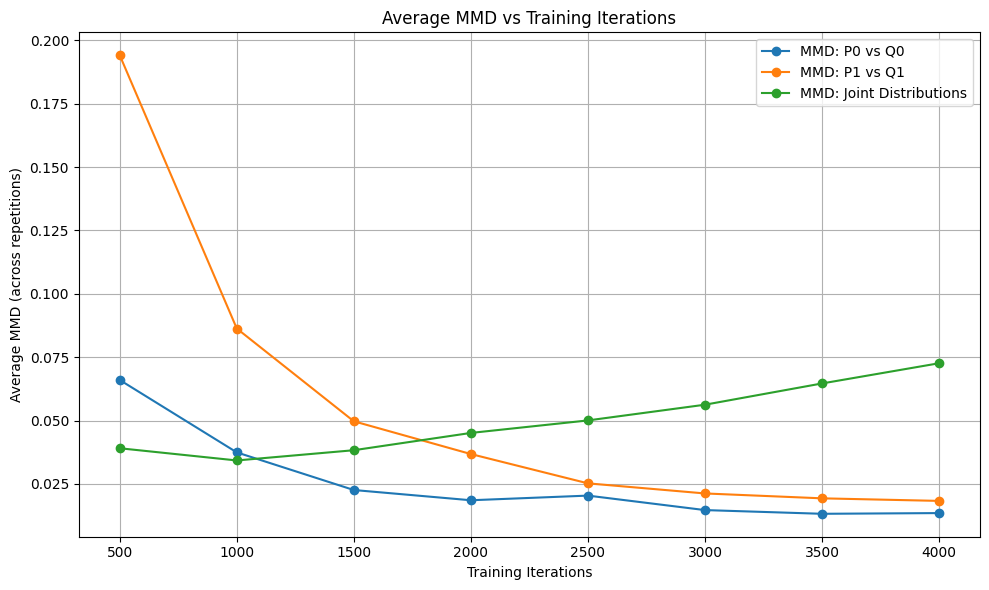

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


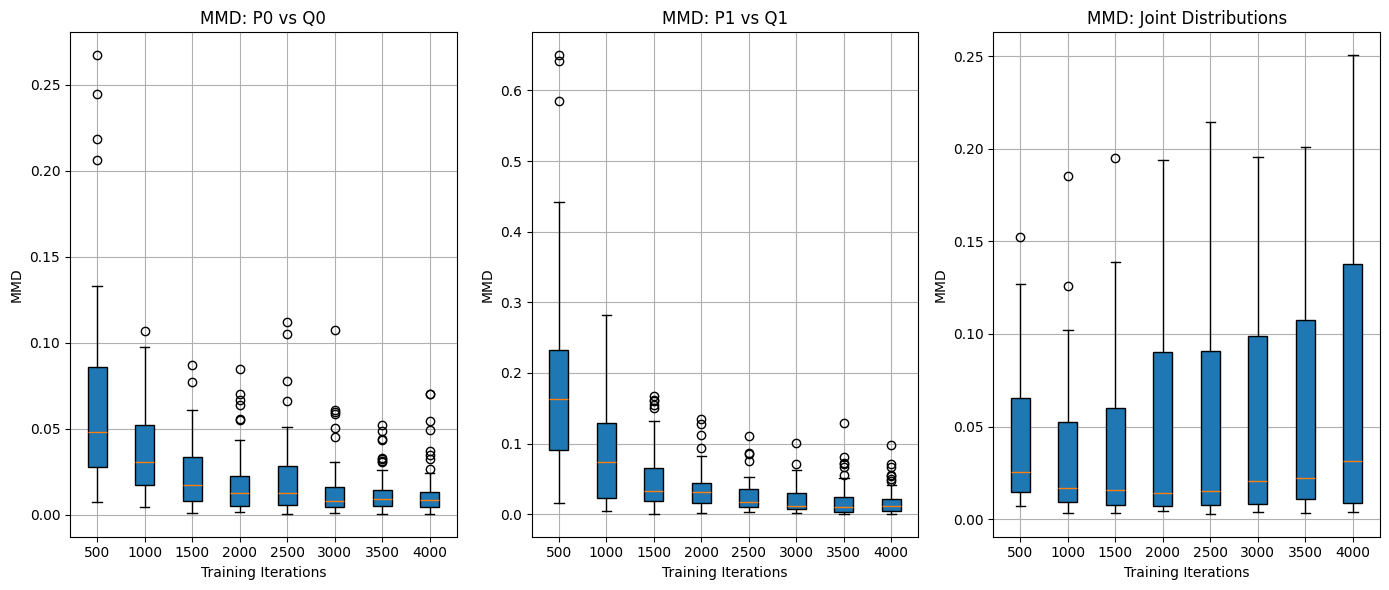

In [22]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


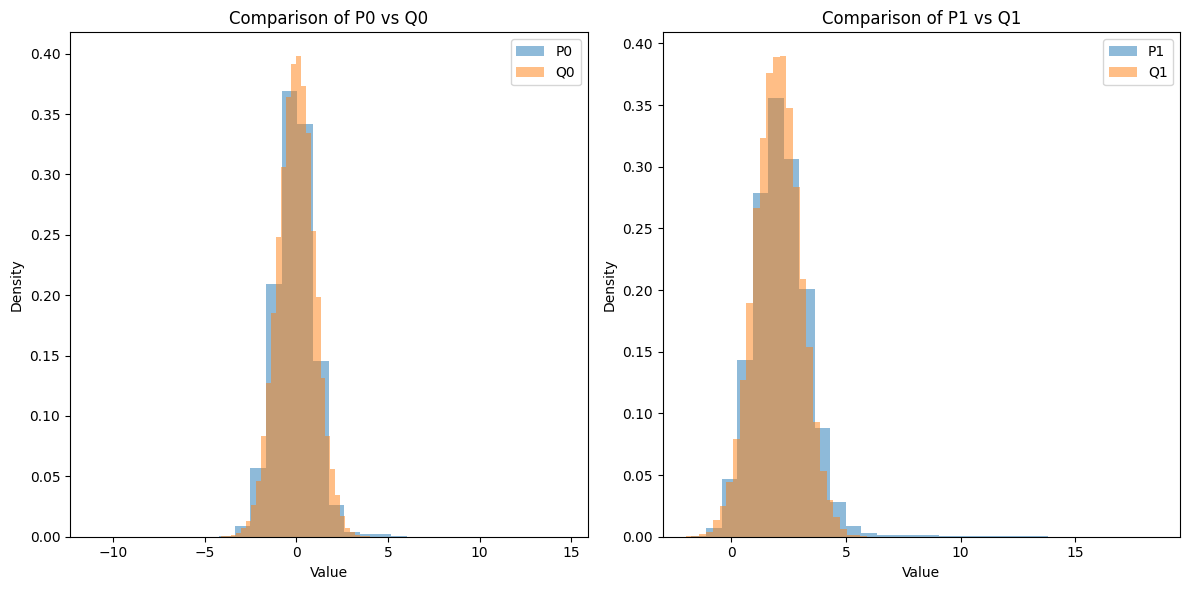

In [25]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()